In [7]:
%matplotlib inline
import matplotlib.pyplot as plt

In [8]:
from pyke.prf import SimpleKeplerPRF

In [9]:
prf = SimpleKeplerPRF(channel=16, shape=(11, 11), column=250, row=200)

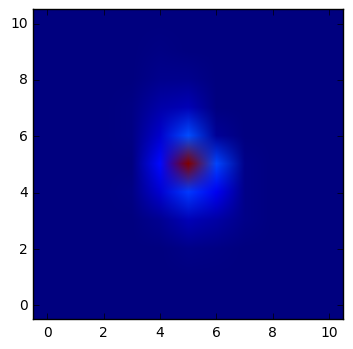

In [10]:
plt.imshow(prf(flux=1e4, center_col=255.5, center_row=205.5), origin='lower')

In [11]:
import numpy as np
from scipy import signal

In [12]:
cadences = np.arange(1000)

In [13]:
A = 1e4 + 1e2 * np.sin(2 * np.pi * np.linspace(0, 6, 1000)) + 300 * np.linspace(0, 1, 1000)
xc = 255.5 + 0.05 + .9*signal.sawtooth(np.linspace(0, 100, 1000))
yc = 205.5 + 0.05 + .9 - .9*signal.sawtooth(np.linspace(0, 100, 1000))

In [14]:
tpf = 1 + np.array([np.random.poisson(prf(flux=A[i], center_col=xc[i], center_row=yc[i]) + 3) for i in range(1000)], dtype=np.float64)
tpf_save = np.copy(tpf)

In [15]:
#tpf[:, 4, 3] = .9 * tpf[:, 4, 3]

In [16]:
#tpf[:, 5, 6] = 1.05 * tpf[:, 5, 6]

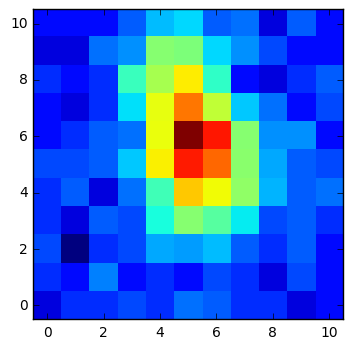

In [17]:
plt.imshow(np.log(tpf[100]), origin='lower', interpolation='nearest')

In [18]:
true_detector = np.ones(tpf.shape[1:])

In [19]:
#true_detector[4, 3] = .9 * true_detector[4, 3]
#true_detector[5, 6] = 1.05 * true_detector[5, 6]

In [20]:
true_detector.shape

(11, 11)

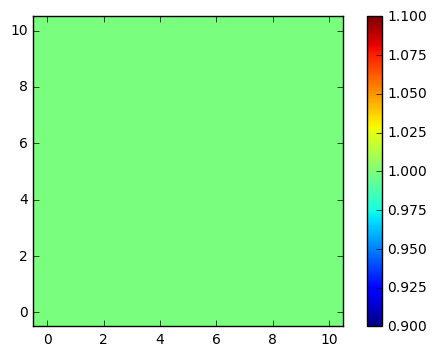

In [21]:
plt.imshow(true_detector, origin='lower')
plt.colorbar()

In [22]:
lc = np.sum(tpf, axis=(1,2))

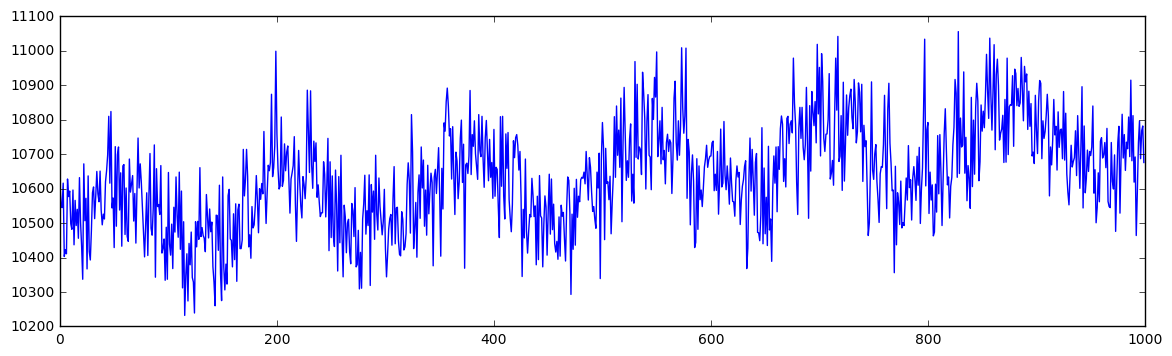

In [23]:
plt.figure(figsize=[14, 4])
plt.plot(cadences, lc)

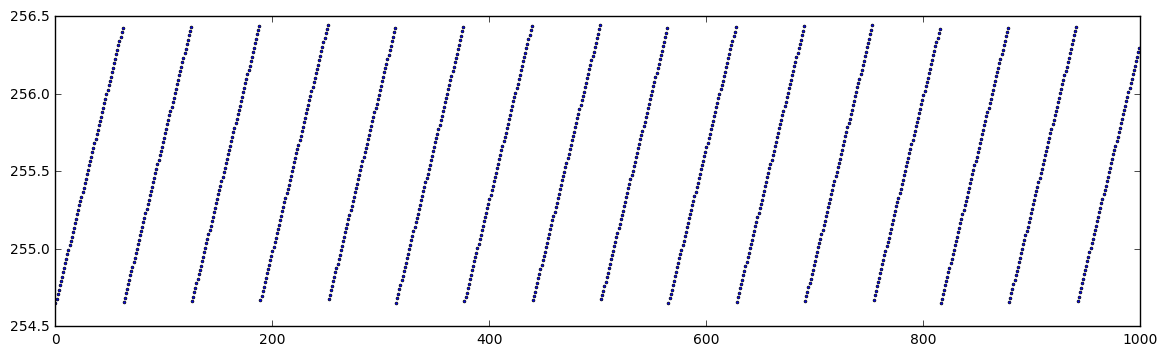

In [24]:
plt.figure(figsize=[14, 4])
plt.plot(cadences, xc, 'o', markersize=2)

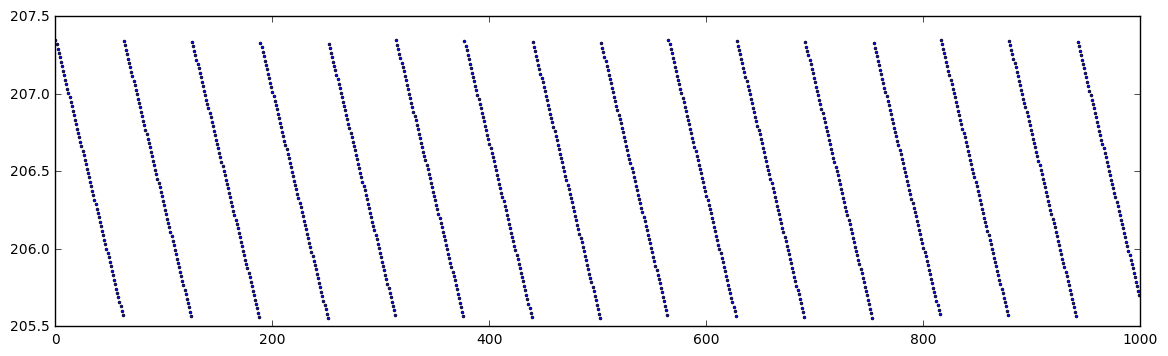

In [25]:
plt.figure(figsize=[14, 4])
plt.plot(cadences, yc, 'o', markersize=2)

In [26]:
from pyke.prf import PRFPhotometry

In [27]:
from oktopus.models import IntegratedSymmetricGaussian2D

In [28]:
from oktopus.prior import UniformPrior

In [29]:
y, x = np.indices(prf.shape) + 0.5

In [30]:
x = x + 250
y = y + 200

In [31]:
psf = IntegratedSymmetricGaussian2D(x, y)

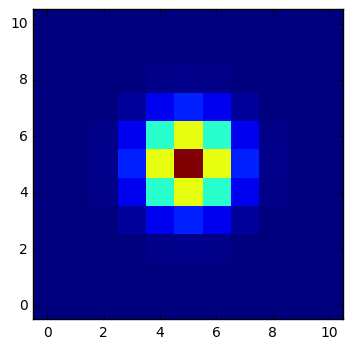

In [32]:
plt.imshow(psf(1000, 255.5, 205.5, 1), origin='lower', interpolation='nearest')

In [33]:
prior = UniformPrior(lb=[5e3, 252.5, 202.5, .25],
                     ub=[15e3, 258.5, 208.5, 1.25])

In [34]:
phot_poisson = PRFPhotometry(scene_model=psf, prior=prior)

In [35]:
results_poisson = phot_poisson.fit(tpf_flux=tpf)

  0%|          | 0/1000 [00:00<?, ?it/s]/Users/ozymandias1/anaconda2/envs/python3/lib/python3.5/site-packages/autograd-1.1.13-py3.5.egg/autograd/core.py:81: RuntimeWarning: divide by zero encountered in log
  result_value = self.fun(*argvals, **kwargs)
/Users/ozymandias1/anaconda2/envs/python3/lib/python3.5/site-packages/scipy/optimize/optimize.py:1876: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
/Users/ozymandias1/anaconda2/envs/python3/lib/python3.5/site-packages/scipy/optimize/optimize.py:1877: RuntimeWarning: invalid value encountered in double_scalars
  p = (x - v) * tmp2 - (x - w) * tmp1
100%|██████████| 1000/1000 [00:12<00:00, 82.60it/s]


In [36]:
flux = results_poisson[:, 0]
xcenter = results_poisson[:, 1]
ycenter = results_poisson[:, 2]
shape = results_poisson[:, 3]

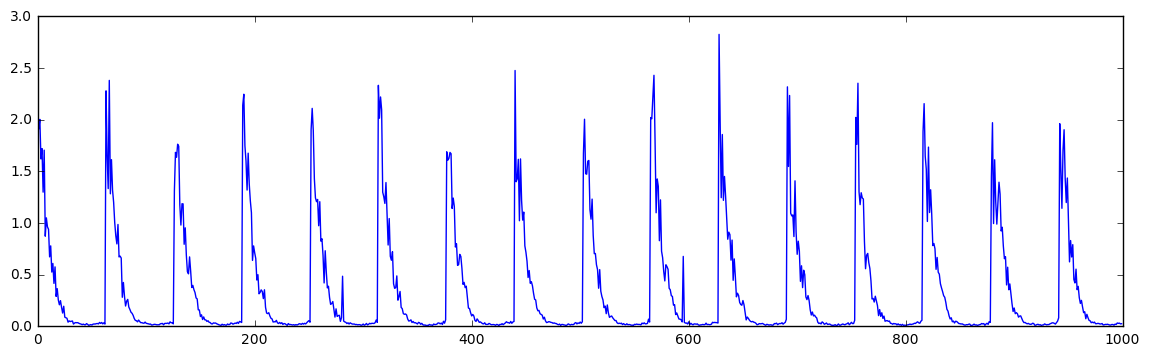

In [37]:
plt.figure(figsize=[14, 4])
plt.plot(cadences, flux - lc)

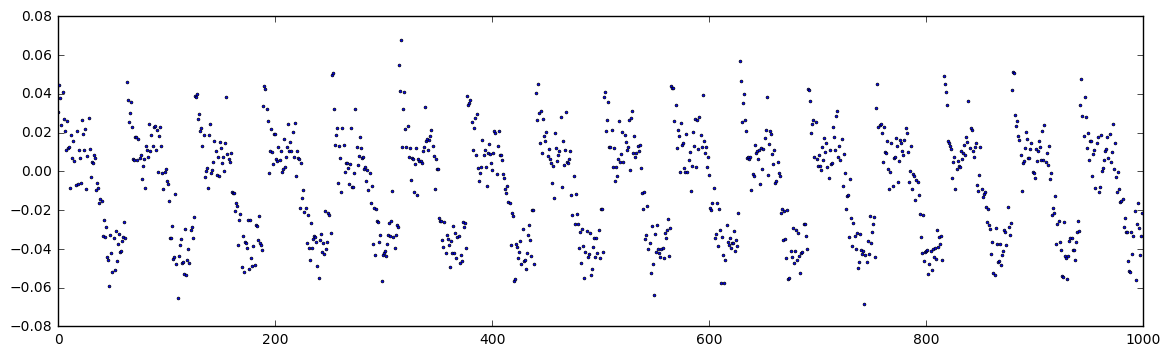

In [38]:
plt.figure(figsize=[14, 4])
plt.plot(cadences, xcenter - xc, 'o', markersize=2)

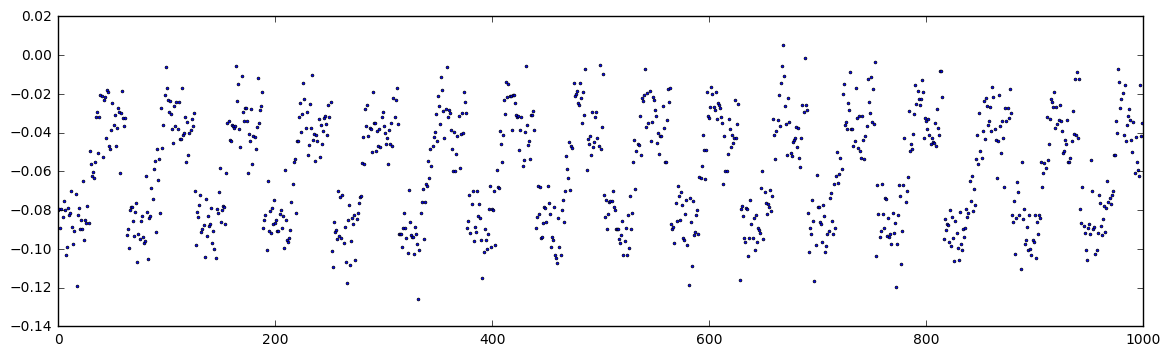

In [39]:
plt.figure(figsize=[14, 4])
plt.plot(cadences, ycenter - yc, 'o', markersize=2)

In [40]:
import numpy as np

In [41]:
x = np.linspace(0, 10, 11)

In [42]:
y = np.linspace(0, 10, 11)

In [43]:
xp = np.linspace(0, 10, 44)
yp = np.linspace(0, 10, 44)

In [44]:
from scipy.interpolate import RectBivariateSpline

In [45]:
tpf = np.log(tpf)

In [46]:
interp = [RectBivariateSpline(x, y, tpf[i], kx=1, ky=1) for i in range(tpf.shape[0])]

In [47]:
super_tpf = np.array([interp[i](yp + (ycenter[i] - 205.5), xp + (xcenter[i] - 255.5)) for i in range(len(xc))])

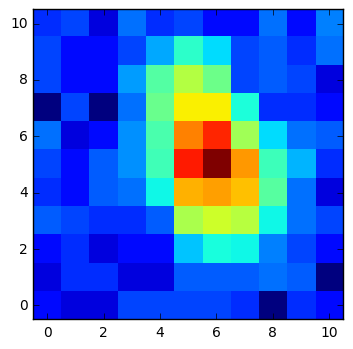

In [48]:
plt.imshow(tpf[-1], origin='lower', interpolation='nearest')

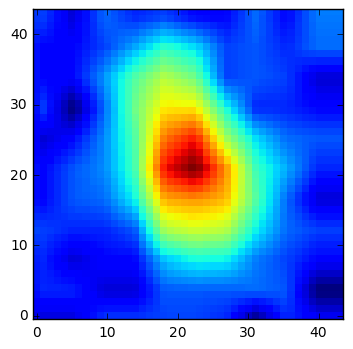

In [49]:
plt.imshow(super_tpf[-1], origin='lower', interpolation='nearest')

In [50]:
mean_super_tpf = np.mean(super_tpf, axis=0)

In [51]:
mean_super_tpf.shape

(44, 44)

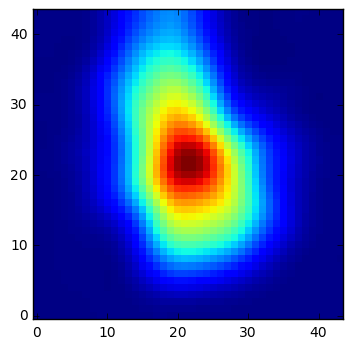

In [52]:
plt.imshow(mean_super_tpf, origin='lower', interpolation='nearest')

In [53]:
norm_super_tpf = mean_super_tpf / np.sum(mean_super_tpf)

In [54]:
np.sum(norm_super_tpf)

1.0

In [55]:
def model_prime(f, dy, dx, template):
    interp_again = RectBivariateSpline(xp, yp, template, kx=1, ky=1)
    return f * interp_again(yp - dy, xp - dx)

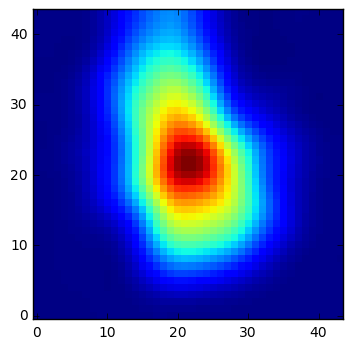

In [56]:
plt.imshow(model_prime(10, 0, 0, norm_super_tpf), origin='lower', interpolation='nearest')

In [57]:
np.sum(model_prime(10, 0, 0, norm_super_tpf))

10.0

In [58]:
def model(f, dy, dx, template):
    tmp = model_prime(f, dy, dx, template).reshape(11, 4, 11, 4)
    return np.sum(tmp, axis=(1, 3))

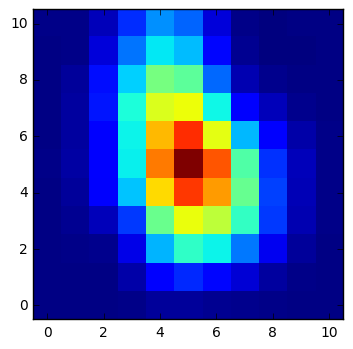

In [59]:
plt.imshow(model(10, 0, 0, norm_super_tpf), origin='lower', interpolation='nearest')

In [60]:
np.sum(model(10, 0, 0, norm_super_tpf))

10.000000000000002

In [61]:
class lnlikelihood:
    def __init__(self, data):
        self.data = data
        
    def evaluate(self, p, template_s, template_d):
        f, dy, dx = p
        r = model(f, dy, dx, template_s) + model(1, 0, 0, template_d) - self.data
        return np.sum(r * r * self.data)

In [62]:
detector = np.zeros((44, 44))

In [63]:
from scipy.optimize import minimize

In [64]:
from tqdm import tqdm

In [65]:
results = []
lnlike = []
for i in tqdm(range(1000)):
    logL = lnlikelihood(data=tpf[i])
    sol = minimize(logL.evaluate, x0=(np.log(1e4), 0, 0), args=(norm_super_tpf, detector), method='Powell')
    results.append(sol.x)
    lnlike.append(sol.fun)

100%|██████████| 1000/1000 [00:45<00:00, 21.96it/s]


In [66]:
results = np.array(results)

In [67]:
center_y = results[:, 1]

In [68]:
center_x = results[:, 2]

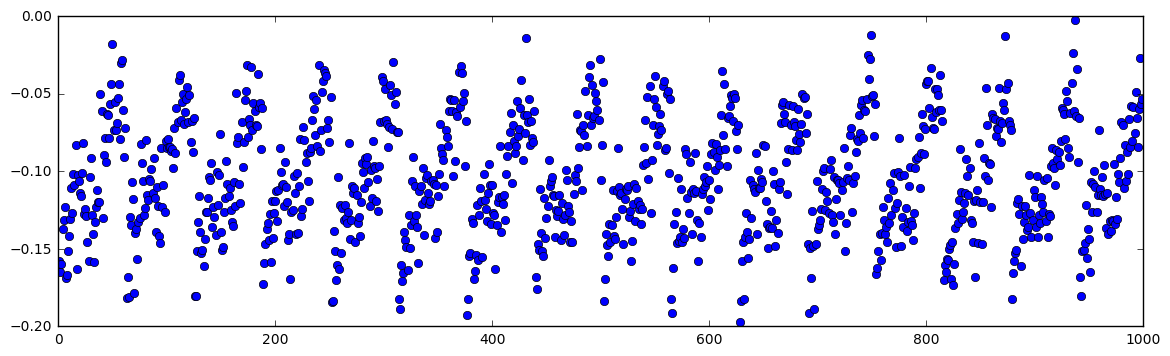

In [69]:
plt.figure(figsize=[14, 4])
plt.plot(np.arange(1000), center_y - (yc - 205.5), 'o')

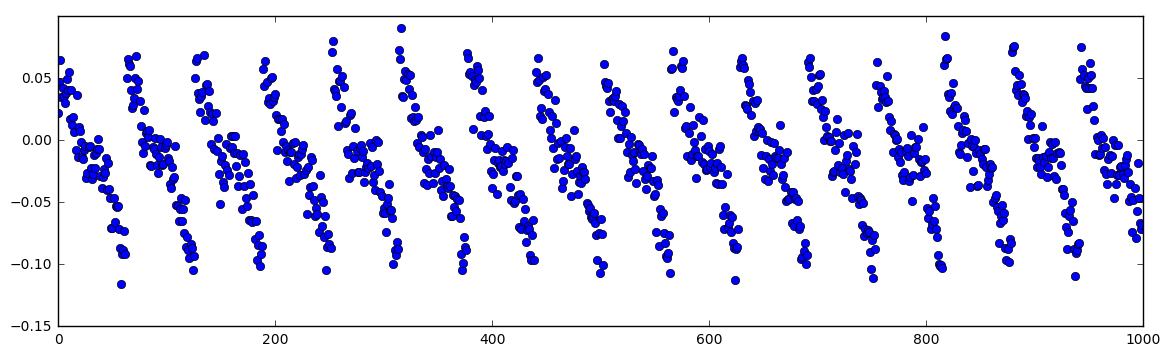

In [70]:
plt.figure(figsize=[14, 4])
plt.plot(np.arange(1000), center_x - (xc - 255.5), 'o')

In [71]:
results.shape

(1000, 3)

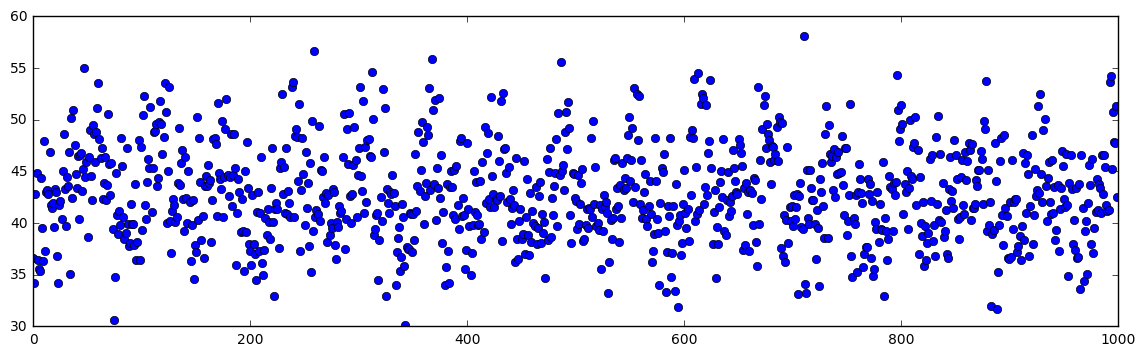

In [72]:
plt.figure(figsize=[14, 4])
plt.plot(np.arange(1000), lnlike, 'o')

In [73]:
results[-1]

array([  2.88426272e+02,   1.48764632e-01,   7.30001401e-01])

In [74]:
np.sum(model(*results[-1], norm_super_tpf))

287.64157773383948

In [75]:
np.sum(tpf[-1])

267.73231233196947

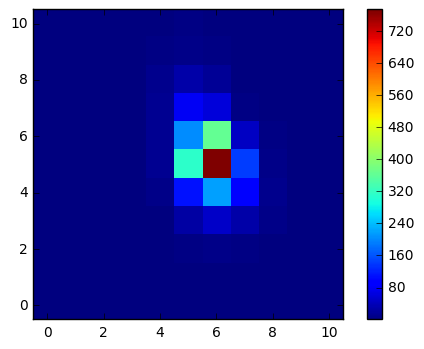

In [76]:
model_ = model(*results[-1], norm_super_tpf)
model_test = model(np.sum(tpf[-1]), results[-1][1], results[-1][2], norm_super_tpf)
plt.imshow(np.exp(model_) - np.exp(model_test), origin='lower', interpolation='nearest', cmap='jet')
plt.colorbar()

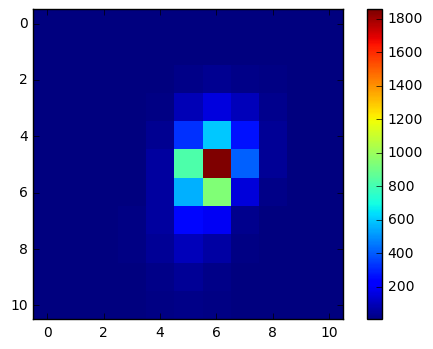

In [77]:
plt.imshow(np.exp(model_), interpolation='nearest')
plt.colorbar()

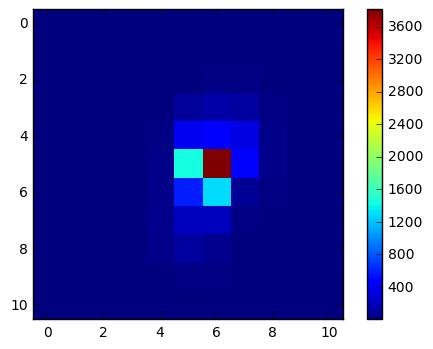

In [78]:
plt.imshow(np.exp(tpf[-1]), interpolation='nearest')
plt.colorbar()

In [79]:
x

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.])

In [80]:
gds = norm_super_tpf

In [81]:
models = [model(*results[i], gds) for i in range(1000)]
interps = [RectBivariateSpline(x, y, models[i] - tpf[i], kx=1, ky=1) for i in range(1000)]

In [82]:
dlnlike_ds = 2 * np.array([results[i, 0] * interps[i](yp - results[i, 1], xp - results[i, 2]) for i in range(1000)])

In [83]:
dlnlike_ds.shape

(1000, 44, 44)

In [84]:
dlnlike_ds = np.sum(dlnlike_ds, axis=0)

In [85]:
dlnlike_ds.shape

(44, 44)

In [86]:
dlnlike_dd = 2 * np.array([interps[i](yp, xp) for i in range(1000)])

In [87]:
dlnlike_dd = np.sum(dlnlike_dd, axis=0)

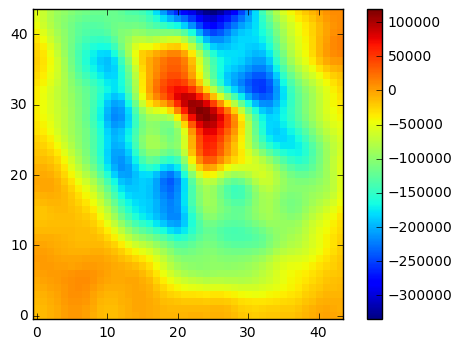

In [88]:
plt.imshow(-dlnlike_ds, origin='lower', interpolation='nearest')
plt.colorbar()

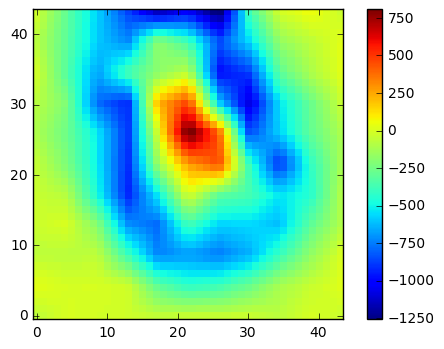

In [89]:
plt.imshow(-dlnlike_dd, origin='lower', interpolation='nearest')
plt.colorbar()

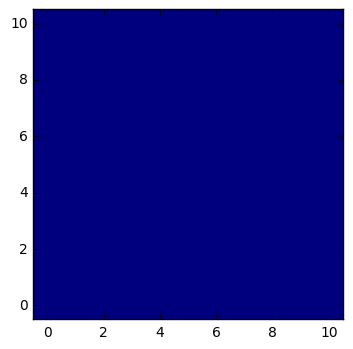

In [90]:
plt.imshow(true_detector, origin='lower')

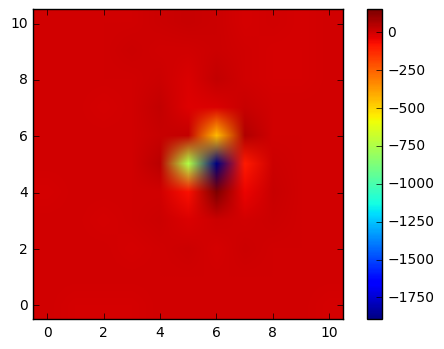

In [91]:
plt.imshow(np.exp(models[-2]) - np.exp(tpf[-2]), origin='lower')
plt.colorbar()

In [92]:
dlnlike_ds.shape

(44, 44)

In [93]:
gds = np.copy(norm_super_tpf)

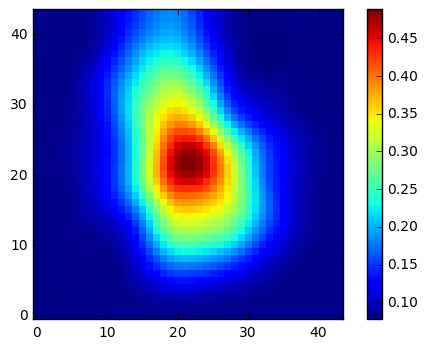

In [94]:
plt.imshow(results[0, 0] * gds, origin='lower', interpolation='nearest')
plt.colorbar()

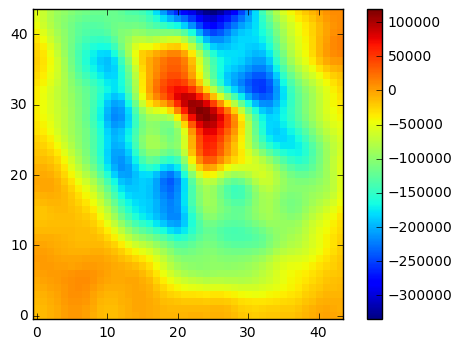

In [95]:
plt.imshow(-dlnlike_ds, origin='lower', interpolation='nearest')
plt.colorbar()

In [96]:
def gradient_descent_ds(template_s, template_d, p):
    f_n, yc_n, xc_n = p
    j = 0
    c = 1e-12
    tmp_s = template_s
    models = [model(f_n[i], yc_n[i], xc_n[i], tmp_s) + model(1, 0, 0, template_d) for i in range(1000)]
    interps = [RectBivariateSpline(x, y, models[i] - tpf[i], kx=1, ky=1) for i in range(1000)]
    dlnlike_ds = 2 * np.array([f_n[i] * interps[i](yp - yc_n[i], xp - xc_n[i]) for i in range(1000)])
    dlnlike_ds = np.sum(dlnlike_ds, axis=0)
    logL_before = np.sum([lnlikelihood(data=tpf[i]).evaluate((f_n[i], yc_n[i], xc_n[i]), tmp_s, template_d)
                          for i in range(1000)])
    while j < 2000:
        tmp_s = tmp_s - c * dlnlike_ds
        logL_after = np.sum([lnlikelihood(data=tpf[i]).evaluate((f_n[i], yc_n[i], xc_n[i]), tmp_s, template_d)
                             for i in range(1000)])
        models = [model(f_n[i], yc_n[i], xc_n[i], tmp_s) + model(1, 0, 0, template_d) for i in range(1000)]
        interps = [RectBivariateSpline(x, y, models[i] - tpf[i], kx=1, ky=1) for i in range(1000)]
        dlnlike_ds = 2 * np.array([f_n[i] * interps[i](yp - yc_n[i], xp - xc_n[i]) for i in range(1000)])
        dlnlike_ds = np.sum(dlnlike_ds, axis=0)
        print(logL_before)
        print(logL_after)
        if logL_after < logL_before:
            c *= 1.1
        else:
            c *= .5
        if (logL_before - logL_after) / logL_before < 1e-6:
            break
        logL_before = logL_after
        j += 1
    return tmp_s

In [97]:
def gradient_descent_dd(template_s, template_d, p):
    f_n, yc_n, xc_n = p
    j = 0
    c = 1e-9
    tmp_d = template_d
    models = [model(f_n[i], yc_n[i], xc_n[i], template_s) + model(1, 0, 0, tmp_d) for i in range(1000)]
    interps = [RectBivariateSpline(x, y, models[i] - tpf[i], kx=1, ky=1) for i in range(1000)]
    dlnlike_dd = 2 * np.array([interps[i](yp, xp) for i in range(1000)])
    dlnlike_dd = np.sum(dlnlike_dd, axis=0)
    logL_before = np.sum([lnlikelihood(data=tpf[i]).evaluate((f_n[i], yc_n[i], xc_n[i]), template_s, tmp_d)
                              for i in range(1000)])
    while j < 2000:
        tmp_d = tmp_d - c * dlnlike_dd
        logL_after = np.sum([lnlikelihood(data=tpf[i]).evaluate((f_n[i], yc_n[i], xc_n[i]), template_s, tmp_d)
                             for i in range(1000)])
        models = [model(f_n[i], yc_n[i], xc_n[i], template_s) + model(1, 0, 0, tmp_d) for i in range(1000)]
        interps = [RectBivariateSpline(x, y, models[i] - tpf[i], kx=1, ky=1) for i in range(1000)]
        dlnlike_dd = 2 * np.array([interps[i](yp, xp) for i in range(1000)])
        dlnlike_dd = np.sum(dlnlike_dd, axis=0)
        print(logL_before)
        print(logL_after)
        if logL_after < logL_before:
            c *= 1.1
        else:
            c *= .5
        if (logL_before - logL_after) / logL_before < 1e-6:
            break
        logL_before = logL_after
        j += 1
    return tmp_d

In [98]:
gdd=np.zeros((44, 44))

In [99]:
gds = gradient_descent_ds(gds, detector, (results[:, 0], results[:, 1], results[:, 2]))
#gds = gds / np.sum(gds)

42924.2316397
42907.6515194
42907.6515194
42889.5640863
42889.5640863
42869.84921
42869.84921
42848.3808344
42848.3808344
42825.0275554
42825.0275554
42799.6534666
42799.6534666
42772.1193354
42772.1193354
42742.2841788
42742.2841788
42710.0073212
42710.0073212
42675.1510256
42675.1510256
42637.583805
42637.583805
42597.1845285
42597.1845285
42553.8474514
42553.8474514
42507.488305
42507.488305
42458.0515899
42458.0515899
42405.5192162
42405.5192162
42349.9206291
42349.9206291
42291.3445423
42291.3445423
42229.9523707
42229.9523707
42165.9934075
42165.9934075
42099.8217235
42099.8217235
42031.9146655
42031.9146655
41962.8927114
41962.8927114
41893.5402721
41893.5402721
41824.8268432
41824.8268432
41757.9276787
41757.9276787
41694.2429224
41694.2429224
41635.413888
41635.413888
41583.3349811
41583.3349811
41540.1596525
41540.1596525
41508.2988411
41508.2988411
41490.4107334
41490.4107334
41489.3814563
41489.3814563
41508.2977361


In [100]:
gdd = gradient_descent_dd(gds, detector, (results[:, 0], results[:, 1], results[:, 2]))

41508.2977361
41507.7477898
41507.7477898
41507.1428846
41507.1428846
41506.4775319
41506.4775319
41505.7456962
41505.7456962
41504.9407401
41504.9407401
41504.0553648
41504.0553648
41503.0815443
41503.0815443
41502.0104537
41502.0104537
41500.8323893
41500.8323893
41499.5366822
41499.5366822
41498.1116025
41498.1116025
41496.5442544
41496.5442544
41494.8204614
41494.8204614
41492.9246398
41492.9246398
41490.8396604
41490.8396604
41488.5466963
41488.5466963
41486.0250567
41486.0250567
41483.2520042
41483.2520042
41480.2025551
41480.2025551
41476.8492603
41476.8492603
41473.1619653
41473.1619653
41469.1075489
41469.1075489
41464.6496357
41464.6496357
41459.7482835
41459.7482835
41454.3596409
41454.3596409
41448.4355744
41448.4355744
41441.9232616
41441.9232616
41434.7647483
41434.7647483
41426.8964663
41426.8964663
41418.2487104
41418.2487104
41408.7450696
41408.7450696
41398.3018122
41398.3018122
41386.8272197
41386.8272197
41374.2208681
41374.2208681
41360.3728542
41360.3728542
41345.

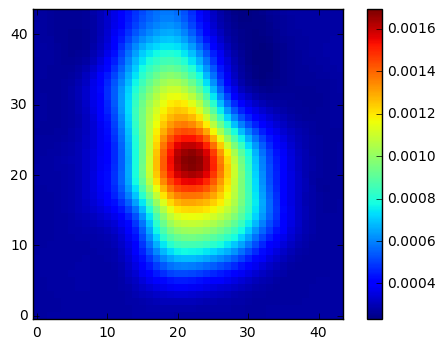

In [101]:
plt.imshow(gds, origin='lower', interpolation='nearest')
plt.colorbar()

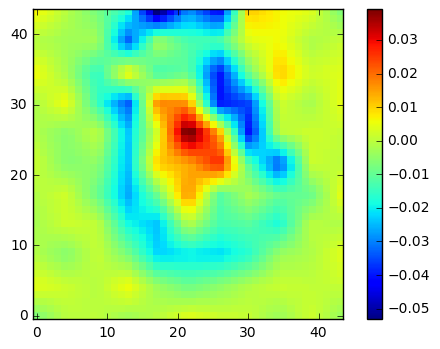

In [102]:
plt.imshow(gdd, origin='lower', interpolation='nearest')
plt.colorbar()

In [103]:
np.sum(gds)

0.96980466225026007

In [104]:
f_n, yc_n, xc_n = results[:, 0], results[:, 1], results[:, 2]

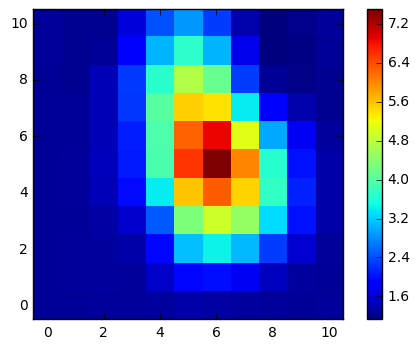

In [105]:
n=-1
plt.imshow(model(f_n[n], yc_n[n], xc_n[n], gds) + model(1, 0, 0, detector), origin='lower', interpolation='nearest')
plt.colorbar()

In [106]:
results = []
lnlike = []
for i in tqdm(range(1000)):
    logL = lnlikelihood(data=tpf[i])
    sol = minimize(logL.evaluate, x0=(f_n[i], yc_n[i], xc_n[i]), args=(gds, detector), method='Powell')
    print(sol)
    results.append(sol.x)
    lnlike.append(sol.fun)

  1%|          | 6/1000 [00:00<00:40, 24.51it/s]

   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 33.66992601236629
 message: 'Optimization terminated successfully.'
    nfev: 97
     nit: 3
  status: 0
 success: True
       x: array([ 292.54772542,    1.63171247,   -0.84673471])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 31.926764862862804
 message: 'Optimization terminated successfully.'
    nfev: 81
     nit: 2
  status: 0
 success: True
       x: array([ 291.97372115,    1.62790689,   -0.7984483 ])
   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [  9.07888580e-03,   7.52788692e-04,  -1.39546293e-04]])
     fun: 39.323583480396223
 message: 'Optimization terminated successfully.'
    nfev: 105
     nit: 3
  status: 0
 success: True
       x: array([ 292.62617987,    1.58698743,   -0.7505185 ])
   direc: array([[  1.00000000e+00,   0.00000000e+00

  1%|          | 12/1000 [00:00<00:38, 25.49it/s]

   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 34.587298617909028
 message: 'Optimization terminated successfully.'
    nfev: 95
     nit: 3
  status: 0
 success: True
       x: array([ 292.17054021,    1.49986926,   -0.6646639 ])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 40.515273572109891
 message: 'Optimization terminated successfully.'
    nfev: 97
     nit: 3
  status: 0
 success: True
       x: array([ 291.21626166,    1.42240703,   -0.62928886])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 36.864046357064204
 message: 'Optimization terminated successfully.'
    nfev: 99
     nit: 3
  status: 0
 success: True
       x: array([ 292.15067058,    1.39634998,   -0.59087255])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 33.213249771580863
 message: 'Optimization terminated successfully.'
    nfe

  2%|▏         | 15/1000 [00:00<00:37, 25.97it/s]

   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 41.065767284449649
 message: 'Optimization terminated successfully.'
    nfev: 65
     nit: 2
  status: 0
 success: True
       x: array([ 293.81920912,    1.33476689,   -0.47407328])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 40.844313025260817
 message: 'Optimization terminated successfully.'
    nfev: 139
     nit: 2
  status: 0
 success: True
       x: array([ 292.2845161 ,    1.28342108,   -0.46511628])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 41.120947903075511
 message: 'Optimization terminated successfully.'
    nfev: 99
     nit: 3
  status: 0
 success: True
       x: array([ 293.86472462,    1.28822487,   -0.44233626])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 43.652389293402663
 message: 'Optimization terminated successfully.'
    nf

  2%|▏         | 21/1000 [00:00<00:37, 26.17it/s]

   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 39.155516811921423
 message: 'Optimization terminated successfully.'
    nfev: 125
     nit: 3
  status: 0
 success: True
       x: array([ 292.2713595 ,    1.1627907 ,   -0.34918468])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 39.735596798651684
 message: 'Optimization terminated successfully.'
    nfev: 96
     nit: 3
  status: 0
 success: True
       x: array([ 295.20458521,    1.17371654,   -0.36279345])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 37.459857822087635
 message: 'Optimization terminated successfully.'
    nfev: 80
     nit: 2
  status: 0
 success: True
       x: array([ 292.85241153,    1.16279035,   -0.31519351])
   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [  1.25570605e-02,   7.29

  3%|▎         | 27/1000 [00:01<00:35, 27.54it/s]

   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 31.765718424861145
 message: 'Optimization terminated successfully.'
    nfev: 96
     nit: 3
  status: 0
 success: True
       x: array([  2.92281868e+02,   1.04866526e+00,  -2.19472863e-01])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 38.712400529661139
 message: 'Optimization terminated successfully.'
    nfev: 93
     nit: 3
  status: 0
 success: True
       x: array([  2.94215925e+02,   9.80530264e-01,  -1.83881715e-01])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 38.997563013417903
 message: 'Optimization terminated successfully.'
    nfev: 96
     nit: 3
  status: 0
 success: True
       x: array([  2.91169497e+02,   9.52368403e-01,  -1.53057339e-01])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 36.651741593108625
 message: 'Optimization termin

  3%|▎         | 33/1000 [00:01<00:34, 28.28it/s]

   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [  1.10694194e-02,   6.15771944e-04,  -1.19538891e-04]])
     fun: 39.692116570420168
 message: 'Optimization terminated successfully.'
    nfev: 104
     nit: 3
  status: 0
 success: True
       x: array([  2.90253537e+02,   8.53229256e-01,  -4.08120660e-02])
   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [  1.20371589e-02,   7.38421834e-04,  -1.43598471e-04]])
     fun: 36.672483879669045
 message: 'Optimization terminated successfully.'
    nfev: 104
     nit: 3
  status: 0
 success: True
       x: array([  2.91090501e+02,   8.41309438e-01,  -3.18447783e-02])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 40.351610393129143
 message: 'Optimization terminated successfully.'
    nfev: 85
     nit: 2
  sta

  4%|▍         | 40/1000 [00:01<00:33, 29.09it/s]

   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [  7.59124085e-03,   8.43831561e-04,  -1.58404831e-04]])
     fun: 39.852280322245136
 message: 'Optimization terminated successfully.'
    nfev: 104
     nit: 3
  status: 0
 success: True
       x: array([  2.91277593e+02,   6.82212215e-01,   1.49333209e-01])
   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [  1.19916158e-02,   7.13087354e-04,  -1.35057947e-04]])
     fun: 47.60759368926135
 message: 'Optimization terminated successfully.'
    nfev: 107
     nit: 3
  status: 0
 success: True
       x: array([  2.91534405e+02,   6.11914791e-01,   1.90167524e-01])
   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [  8.63203413e-03,   6.60933705e-04,  -1.23990979e

  5%|▍         | 47/1000 [00:01<00:34, 27.64it/s]

   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 43.225961070921649
 message: 'Optimization terminated successfully.'
    nfev: 95
     nit: 3
  status: 0
 success: True
       x: array([ 292.01580978,    0.48167688,    0.33707812])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 42.689419138415275
 message: 'Optimization terminated successfully.'
    nfev: 131
     nit: 3
  status: 0
 success: True
       x: array([ 292.58345492,    0.46511626,    0.37105494])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 40.674757457071586
 message: 'Optimization terminated successfully.'
    nfev: 119
     nit: 3
  status: 0
 success: True
       x: array([ 294.84748557,    0.46511554,    0.37406034])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 43.905378655825956
 message: 'Optimization terminated successfully.'
    n

  5%|▌         | 53/1000 [00:01<00:38, 24.28it/s]

   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 43.610302024247602
 message: 'Optimization terminated successfully.'
    nfev: 97
     nit: 3
  status: 0
 success: True
       x: array([ 293.00274706,    0.34148263,    0.47070835])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 35.886006966156167
 message: 'Optimization terminated successfully.'
    nfev: 96
     nit: 3
  status: 0
 success: True
       x: array([ 292.1480627 ,    0.33722476,    0.49810977])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 42.283840455515708
 message: 'Optimization terminated successfully.'
    nfev: 95
     nit: 3
  status: 0
 success: True
       x: array([  2.93730287e+02,   2.57093245e-01,   5.49980500e-01])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 46.906894758060275
 message: 'Optimization terminated successfully.

  6%|▌         | 60/1000 [00:02<00:37, 25.06it/s]

   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 41.888835449379499
 message: 'Optimization terminated successfully.'
    nfev: 99
     nit: 3
  status: 0
 success: True
       x: array([  2.94664166e+02,   2.30436000e-01,   5.93273510e-01])
   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [  1.18485763e-02,   7.26170804e-04,  -1.41724049e-04]])
     fun: 38.132227822103012
 message: 'Optimization terminated successfully.'
    nfev: 104
     nit: 3
  status: 0
 success: True
       x: array([  2.93954006e+02,   1.93401935e-01,   6.21942249e-01])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 45.652022042994382
 message: 'Optimization terminated successfully.'
    nfev: 96
     nit: 3
  status: 0
 success: True
       x: array([  2.92338766e+02,   1.59858242e-01,   6.54000529e-01])
   direc: array([[ 1.,  

  7%|▋         | 66/1000 [00:02<00:34, 26.75it/s]

   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 48.201483573547428
 message: 'Optimization terminated successfully.'
    nfev: 96
     nit: 3
  status: 0
 success: True
       x: array([  2.89399123e+02,   7.31391460e-03,   7.67026738e-01])
   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [  9.04304456e-04,   7.09848107e-04,  -1.30669342e-04]])
     fun: 43.974586062654183
 message: 'Optimization terminated successfully.'
    nfev: 104
     nit: 3
  status: 0
 success: True
       x: array([  2.91983170e+02,  -1.84110259e-02,   8.05433686e-01])
   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [  7.68110907e-03,   5.91206744e-04,  -1.08450629e-04]])
     fun: 41.379016842988086
 message: 'Optimization terminated successfully.'
    nfev: 104
     nit: 3
  sta

  7%|▋         | 70/1000 [00:02<00:33, 28.09it/s]

   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [  6.34023183e-03,   4.80260105e-04,  -9.53187652e-05]])
     fun: 44.70078859431522
 message: 'Optimization terminated successfully.'
    nfev: 103
     nit: 3
  status: 0
 success: True
       x: array([ 293.12515635,    1.57550459,   -0.71108426])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 42.086655155284738
 message: 'Optimization terminated successfully.'
    nfev: 77
     nit: 2
  status: 0
 success: True
       x: array([ 292.86243124,    1.53075601,   -0.69767432])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 40.688725418675133
 message: 'Optimization terminated successfully.'
    nfev: 97
     nit: 3
  status: 0
 success: True
       x: array([ 291.51620812,    1.53418812,   -0.69065718])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1., 

  8%|▊         | 77/1000 [00:02<00:31, 28.97it/s]

   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [  7.57661317e-03,   7.91100193e-04,  -1.46922845e-04]])
     fun: 37.392958823232327
 message: 'Optimization terminated successfully.'
    nfev: 106
     nit: 3
  status: 0
 success: True
       x: array([ 293.37350606,    1.37679478,   -0.54059576])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 28.404402776265911
 message: 'Optimization terminated successfully.'
    nfev: 98
     nit: 3
  status: 0
 success: True
       x: array([ 295.29668693,    1.34682458,   -0.50153409])
   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [  1.06274207e-02,   7.60594371e-04,  -1.45064155e-04]])
     fun: 33.290699251606547
 message: 'Optimization terminated successfully.'
    nfev: 104
     nit: 3
  status: 0
 success: T

  8%|▊         | 85/1000 [00:03<00:31, 29.37it/s]

   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 37.20130535712692
 message: 'Optimization terminated successfully.'
    nfev: 96
     nit: 3
  status: 0
 success: True
       x: array([ 293.51462524,    1.17686413,   -0.37641049])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 45.25025723174344
 message: 'Optimization terminated successfully.'
    nfev: 96
     nit: 3
  status: 0
 success: True
       x: array([ 290.00152552,    1.19120957,   -0.33928762])
   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [  1.18873850e-03,   8.30521525e-04,  -1.58472847e-04]])
     fun: 41.446846244951331
 message: 'Optimization terminated successfully.'
    nfev: 106
     nit: 3
  status: 0
 success: True
       x: array([ 292.33897123,    1.15159579,   -0.31565379])
   direc: array([[  1.00000000e+00,   0.00000000e+00,

  9%|▉         | 93/1000 [00:03<00:29, 30.27it/s]

   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 36.074371335690408
 message: 'Optimization terminated successfully.'
    nfev: 94
     nit: 3
  status: 0
 success: True
       x: array([  2.93549387e+02,   9.82655620e-01,  -1.75002393e-01])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 35.488721151649429
 message: 'Optimization terminated successfully.'
    nfev: 95
     nit: 3
  status: 0
 success: True
       x: array([  2.91650642e+02,   9.79711210e-01,  -1.49601046e-01])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 34.142085946965885
 message: 'Optimization terminated successfully.'
    nfev: 78
     nit: 2
  status: 0
 success: True
       x: array([  2.91704343e+02,   9.30233734e-01,  -1.14840627e-01])
   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
      

 10%|▉         | 97/1000 [00:03<00:29, 30.26it/s]

   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 41.359515118991673
 message: 'Optimization terminated successfully.'
    nfev: 95
     nit: 3
  status: 0
 success: True
       x: array([  2.91568916e+02,   7.49268079e-01,   3.12373911e-02])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 33.964405280907073
 message: 'Optimization terminated successfully.'
    nfev: 95
     nit: 3
  status: 0
 success: True
       x: array([  2.90917704e+02,   7.84719765e-01,   5.33194359e-02])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 33.862984003756701
 message: 'Optimization terminated successfully.'
    nfev: 94
     nit: 3
  status: 0
 success: True
       x: array([  2.91208090e+02,   7.14214879e-01,   6.70694673e-02])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 44.106973847404852
 message: 'Optimization termin

 10%|█         | 104/1000 [00:03<00:34, 25.90it/s]

   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 44.490295365503584
 message: 'Optimization terminated successfully.'
    nfev: 80
     nit: 2
  status: 0
 success: True
       x: array([  2.90532970e+02,   6.97674449e-01,   1.60594498e-01])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 36.838996298355944
 message: 'Optimization terminated successfully.'
    nfev: 98
     nit: 3
  status: 0
 success: True
       x: array([  2.92210721e+02,   6.44000889e-01,   1.95816370e-01])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 48.667442530588943
 message: 'Optimization terminated successfully.'
    nfev: 65
     nit: 2
  status: 0
 success: True
       x: array([  2.90379172e+02,   6.08495208e-01,   2.25681070e-01])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 49.360228860463884
 message: 'Optimization termin

 11%|█         | 107/1000 [00:03<00:35, 24.85it/s]

   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 36.863569087128568
 message: 'Optimization terminated successfully.'
    nfev: 97
     nit: 3
  status: 0
 success: True
       x: array([  2.90482667e+02,   5.25264393e-01,   2.78106616e-01])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 39.871744626103819
 message: 'Optimization terminated successfully.'
    nfev: 95
     nit: 3
  status: 0
 success: True
       x: array([ 290.85476783,    0.49759088,    0.32154727])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 41.843481928255926
 message: 'Optimization terminated successfully.'
    nfev: 77
     nit: 2
  status: 0
 success: True
       x: array([ 291.37683467,    0.46511838,    0.3383486 ])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 41.035003364635173
 message: 'Optimization terminated successfully.

 11%|█▏        | 114/1000 [00:04<00:33, 26.32it/s]

   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 41.990966516771145
 message: 'Optimization terminated successfully.'
    nfev: 98
     nit: 3
  status: 0
 success: True
       x: array([ 292.94971898,    0.37026838,    0.43098713])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 46.655241997666074
 message: 'Optimization terminated successfully.'
    nfev: 80
     nit: 2
  status: 0
 success: True
       x: array([ 291.71913277,    0.36132032,    0.4651163 ])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 44.871805789731567
 message: 'Optimization terminated successfully.'
    nfev: 96
     nit: 3
  status: 0
 success: True
       x: array([ 292.42643114,    0.3397323 ,    0.49215633])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 46.47710717722078
 message: 'Optimization terminated successfully.'
    nfev

 12%|█▏        | 120/1000 [00:04<00:34, 25.79it/s]

   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 44.604552505334603
 message: 'Optimization terminated successfully.'
    nfev: 118
     nit: 3
  status: 0
 success: True
       x: array([  2.89837891e+02,   2.32557997e-01,   5.76675928e-01])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 47.67342954608953
 message: 'Optimization terminated successfully.'
    nfev: 97
     nit: 3
  status: 0
 success: True
       x: array([  2.91774188e+02,   2.10736514e-01,   6.30643805e-01])
   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [  1.04233837e-02,   5.98075937e-04,  -1.14777521e-04]])
     fun: 44.820927510620045
 message: 'Optimization terminated successfully.'
    nfev: 105
     nit: 3
  status: 0
 success: True
       x: array([  2.90705568e+02,   1.50523504e-01,   6.28805286e-01])
   direc: array([[  1.00

 12%|█▏        | 123/1000 [00:04<00:36, 24.09it/s]

   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 48.847799402964782
 message: 'Optimization terminated successfully.'
    nfev: 98
     nit: 3
  status: 0
 success: True
       x: array([  2.90595874e+02,   6.92390417e-02,   7.11379953e-01])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 45.799241127617833
 message: 'Optimization terminated successfully.'
    nfev: 95
     nit: 3
  status: 0
 success: True
       x: array([  2.90174832e+02,   8.64477036e-03,   7.47192506e-01])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 35.293819082215073
 message: 'Optimization terminated successfully.'
    nfev: 133
     nit: 3
  status: 0
 success: True
       x: array([  2.91453277e+02,   1.90715990e-08,   7.74618520e-01])
   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
     

 13%|█▎        | 129/1000 [00:04<00:43, 20.12it/s]

   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [  6.70140058e-03,   7.04925288e-04,  -1.30753470e-04]])
     fun: 46.700199909189514
 message: 'Optimization terminated successfully.'
    nfev: 107
     nit: 3
  status: 0
 success: True
       x: array([  2.89174845e+02,  -5.07147833e-02,   8.20669693e-01])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 36.640186547856729
 message: 'Optimization terminated successfully.'
    nfev: 123
     nit: 3
  status: 0
 success: True
       x: array([ 289.86451623,    1.62790692,   -0.81306404])
   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [  6.26030690e-03,   8.00801785e-04,  -1.51220560e-04]])
     fun: 34.579120394626379
 message: 'Optimization terminated successfully.'
    nfev: 105
     nit: 3
  status: 0
 

 14%|█▎        | 135/1000 [00:05<00:36, 23.57it/s]

   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [  7.15346136e-03,   8.19287896e-04,  -1.55016213e-04]])
     fun: 39.701611305403354
 message: 'Optimization terminated successfully.'
    nfev: 105
     nit: 3
  status: 0
 success: True
       x: array([ 291.87134246,    1.55928425,   -0.7344144 ])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 39.659847239129164
 message: 'Optimization terminated successfully.'
    nfev: 80
     nit: 2
  status: 0
 success: True
       x: array([ 292.10319065,    1.54476272,   -0.69767422])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 36.097372076289162
 message: 'Optimization terminated successfully.'
    nfev: 97
     nit: 3
  status: 0
 success: True
       x: array([ 291.27579319,    1.49367583,   -0.68809934])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,

 14%|█▍        | 141/1000 [00:05<00:34, 25.06it/s]

   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 43.285742432145184
 message: 'Optimization terminated successfully.'
    nfev: 123
     nit: 3
  status: 0
 success: True
       x: array([ 293.71712163,    1.39534884,   -0.53129747])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 44.21562449761192
 message: 'Optimization terminated successfully.'
    nfev: 98
     nit: 3
  status: 0
 success: True
       x: array([ 292.51288402,    1.34780664,   -0.49999711])
   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [  1.11767701e-02,   6.98699386e-04,  -1.37760215e-04]])
     fun: 40.792581071097899
 message: 'Optimization terminated successfully.'
    nfev: 104
     nit: 3
  status: 0
 success: True
       x: array([ 292.40401043,    1.31590694,   -0.4847269 ])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,

 15%|█▍        | 147/1000 [00:05<00:34, 25.01it/s]

   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 37.874172828720567
 message: 'Optimization terminated successfully.'
    nfev: 96
     nit: 3
  status: 0
 success: True
       x: array([ 292.39460739,    1.1870732 ,   -0.37355786])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 42.968712617779147
 message: 'Optimization terminated successfully.'
    nfev: 97
     nit: 3
  status: 0
 success: True
       x: array([ 292.05076561,    1.16864233,   -0.35154376])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 38.420495866577696
 message: 'Optimization terminated successfully.'
    nfev: 99
     nit: 3
  status: 0
 success: True
       x: array([ 293.62701464,    1.15905031,   -0.35044607])
   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [  8.49364859e-03,   6.303

 15%|█▌        | 150/1000 [00:05<00:35, 24.24it/s]

   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 32.532631401320515
 message: 'Optimization terminated successfully.'
    nfev: 137
     nit: 2
  status: 0
 success: True
       x: array([  2.91986836e+02,   1.04063211e+00,  -2.32558140e-01])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 35.792483318190236
 message: 'Optimization terminated successfully.'
    nfev: 84
     nit: 2
  status: 0
 success: True
       x: array([  2.91080190e+02,   1.03934328e+00,  -2.32558140e-01])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 34.407767917751563
 message: 'Optimization terminated successfully.'
    nfev: 95
     nit: 3
  status: 0
 success: True
       x: array([  2.92263453e+02,   9.50803670e-01,  -1.80948291e-01])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 46.958560696052892
 message: 'Optimization termi

 16%|█▌        | 156/1000 [00:06<00:38, 21.78it/s]

   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [ -5.13388836e-03,   8.71565411e-04,  -1.63250235e-04]])
     fun: 37.746763594632299
 message: 'Optimization terminated successfully.'
    nfev: 104
     nit: 3
  status: 0
 success: True
       x: array([  2.90287741e+02,   9.15031968e-01,  -1.48678787e-01])
   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [  2.53017884e-03,   7.20653613e-04,  -1.30546486e-04]])
     fun: 44.847800253356439
 message: 'Optimization terminated successfully.'
    nfev: 106
     nit: 3
  status: 0
 success: True
       x: array([  2.91537551e+02,   9.08813300e-01,  -1.23386020e-01])
   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [  8.31041433e-03,   5.71154800e-04,  -1.06025143

 16%|█▌        | 159/1000 [00:06<00:37, 22.63it/s]

   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 33.890079576820597
 message: 'Optimization terminated successfully.'
    nfev: 96
     nit: 3
  status: 0
 success: True
       x: array([  2.90810832e+02,   7.74724026e-01,   9.41723333e-03])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 41.318640130698228
 message: 'Optimization terminated successfully.'
    nfev: 97
     nit: 3
  status: 0
 success: True
       x: array([  2.91426660e+02,   7.54890655e-01,   5.92127363e-02])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 40.909199130752491
 message: 'Optimization terminated successfully.'
    nfev: 95
     nit: 3
  status: 0
 success: True
       x: array([  2.90550395e+02,   7.10540004e-01,   9.62031672e-02])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 39.528854512613449
 message: 'Optimization termin

 16%|█▋        | 165/1000 [00:06<00:36, 22.73it/s]

   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [  1.10111384e-02,   7.52155746e-04,  -1.44072344e-04]])
     fun: 41.861952487802547
 message: 'Optimization terminated successfully.'
    nfev: 104
     nit: 3
  status: 0
 success: True
       x: array([  2.88859222e+02,   6.63816612e-01,   1.47355908e-01])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 40.840809739792107
 message: 'Optimization terminated successfully.'
    nfev: 97
     nit: 3
  status: 0
 success: True
       x: array([  2.91482181e+02,   6.51878301e-01,   1.64058019e-01])
   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [  1.08731335e-02,   7.46564795e-04,  -1.41493916e-04]])
     fun: 40.471517373068465
 message: 'Optimization terminated successfully.'
    nfev: 104
     nit: 3
  sta

 17%|█▋        | 171/1000 [00:06<00:32, 25.50it/s]

   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 45.680625643201424
 message: 'Optimization terminated successfully.'
    nfev: 93
     nit: 3
  status: 0
 success: True
       x: array([ 291.59961229,    0.4992683 ,    0.29350549])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 43.153491839145765
 message: 'Optimization terminated successfully.'
    nfev: 76
     nit: 2
  status: 0
 success: True
       x: array([ 290.19374818,    0.46511658,    0.33364382])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 36.332424584848397
 message: 'Optimization terminated successfully.'
    nfev: 95
     nit: 3
  status: 0
 success: True
       x: array([ 291.95210495,    0.48054646,    0.32236793])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 47.945081751682743
 message: 'Optimization terminated successfully.'
    nfe

 18%|█▊        | 177/1000 [00:06<00:30, 26.64it/s]

   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 41.349549464492959
 message: 'Optimization terminated successfully.'
    nfev: 98
     nit: 3
  status: 0
 success: True
       x: array([ 292.85961517,    0.38397101,    0.44238878])
   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [ -4.19656814e-03,   4.04890954e-04,  -7.52134583e-05]])
     fun: 45.994437624342027
 message: 'Optimization terminated successfully.'
    nfev: 105
     nit: 3
  status: 0
 success: True
       x: array([ 290.04829974,    0.36512833,    0.4730129 ])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 36.704783920589541
 message: 'Optimization terminated successfully.'
    nfev: 95
     nit: 3
  status: 0
 success: True
       x: array([ 293.06034036,    0.29660574,    0.52710425])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,

 18%|█▊        | 183/1000 [00:07<00:32, 25.48it/s]

   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [  4.22506671e-03,   7.47069752e-04,  -1.43378263e-04]])
     fun: 40.399900318050506
 message: 'Optimization terminated successfully.'
    nfev: 105
     nit: 3
  status: 0
 success: True
       x: array([  2.92660159e+02,   2.14073119e-01,   5.94604703e-01])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 39.252291909445738
 message: 'Optimization terminated successfully.'
    nfev: 98
     nit: 3
  status: 0
 success: True
       x: array([  2.93745605e+02,   1.97265714e-01,   6.43865307e-01])
   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [  1.10637021e-02,   6.94326215e-04,  -1.34322752e-04]])
     fun: 40.145117593962574
 message: 'Optimization terminated successfully.'
    nfev: 105
     nit: 3
  sta

 19%|█▉        | 190/1000 [00:07<00:29, 27.12it/s]

   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 44.109172424333345
 message: 'Optimization terminated successfully.'
    nfev: 95
     nit: 3
  status: 0
 success: True
       x: array([  2.91076181e+02,   2.66652733e-02,   7.64524795e-01])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 40.902057924685813
 message: 'Optimization terminated successfully.'
    nfev: 66
     nit: 2
  status: 0
 success: True
       x: array([  2.92719530e+02,   1.98261407e-03,   7.64794407e-01])
   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [  4.95677625e-03,   7.65631614e-04,  -1.42425229e-04]])
     fun: 31.743720734429143
 message: 'Optimization terminated successfully.'
    nfev: 103
     nit: 3
  status: 0
 success: True
       x: array([  2.91973245e+02,  -2.49451483e-02,   7.98615979e-01])
   direc: array([[  1.00

 19%|█▉        | 193/1000 [00:07<00:29, 27.62it/s]

   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [  9.73888104e-03,   7.86901178e-04,  -1.49459493e-04]])
     fun: 37.709877187999119
 message: 'Optimization terminated successfully.'
    nfev: 104
     nit: 3
  status: 0
 success: True
       x: array([ 292.57479362,    1.57018077,   -0.73010966])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 41.173893235638751
 message: 'Optimization terminated successfully.'
    nfev: 67
     nit: 2
  status: 0
 success: True
       x: array([ 292.98539349,    1.54549587,   -0.69845116])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 35.984729906350744
 message: 'Optimization terminated successfully.'
    nfev: 140
     nit: 3
  status: 0
 success: True
       x: array([ 292.69796338,    1.52678067,   -0.69767442])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.

 20%|█▉        | 199/1000 [00:07<00:35, 22.87it/s]

   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 41.115756606186139
 message: 'Optimization terminated successfully.'
    nfev: 98
     nit: 3
  status: 0
 success: True
       x: array([ 293.97236609,    1.47154383,   -0.64726201])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 37.397560833475112
 message: 'Optimization terminated successfully.'
    nfev: 95
     nit: 3
  status: 0
 success: True
       x: array([ 293.80518391,    1.41426722,   -0.59721473])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 44.857529275972595
 message: 'Optimization terminated successfully.'
    nfev: 96
     nit: 3
  status: 0
 success: True
       x: array([ 293.56062345,    1.42289858,   -0.56940873])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 42.227027148530226
 message: 'Optimization terminated successfully.'
    nfe

 20%|██        | 202/1000 [00:07<00:37, 21.14it/s]

   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 38.126522336308462
 message: 'Optimization terminated successfully.'
    nfev: 98
     nit: 3
  status: 0
 success: True
       x: array([ 295.71589117,    1.35433456,   -0.49921964])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 34.240025927038182
 message: 'Optimization terminated successfully.'
    nfev: 139
     nit: 2
  status: 0
 success: True
       x: array([ 294.30182478,    1.30975113,   -0.46511628])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 40.787040807024027
 message: 'Optimization terminated successfully.'
    nfev: 108
     nit: 2
  status: 0
 success: True
       x: array([ 291.40568545,    1.25938506,   -0.46511628])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 35.148042063298426
 message: 'Optimization terminated successfully.'
    n

 21%|██        | 208/1000 [00:08<00:36, 21.44it/s]

   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 34.407212721286342
 message: 'Optimization terminated successfully.'
    nfev: 95
     nit: 3
  status: 0
 success: True
       x: array([ 294.62847259,    1.25667063,   -0.39783296])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 32.308186626276736
 message: 'Optimization terminated successfully.'
    nfev: 96
     nit: 3
  status: 0
 success: True
       x: array([ 294.47403034,    1.21342827,   -0.3807008 ])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 39.243124206208989
 message: 'Optimization terminated successfully.'
    nfev: 96
     nit: 3
  status: 0
 success: True
       x: array([ 293.90770504,    1.17881226,   -0.34311931])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 39.250870549808262
 message: 'Optimization terminated successfully.'
    nfe

 21%|██▏       | 214/1000 [00:08<00:35, 21.97it/s]

   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 37.092400514433898
 message: 'Optimization terminated successfully.'
    nfev: 97
     nit: 3
  status: 0
 success: True
       x: array([  2.95401460e+02,   1.12204546e+00,  -2.88434537e-01])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 43.44498611414329
 message: 'Optimization terminated successfully.'
    nfev: 65
     nit: 2
  status: 0
 success: True
       x: array([  2.94050835e+02,   1.05332806e+00,  -2.35663500e-01])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 34.265617026824664
 message: 'Optimization terminated successfully.'
    nfev: 95
     nit: 3
  status: 0
 success: True
       x: array([  2.93498693e+02,   1.02060034e+00,  -2.28918184e-01])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 32.001868207161287
 message: 'Optimization termina

 22%|██▏       | 221/1000 [00:08<00:31, 24.75it/s]

   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [ -4.44117267e-03,   7.10302197e-04,  -1.32054522e-04]])
     fun: 37.082333260272328
 message: 'Optimization terminated successfully.'
    nfev: 105
     nit: 3
  status: 0
 success: True
       x: array([  2.92799243e+02,   9.12175678e-01,  -1.43417170e-01])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 35.101200000465724
 message: 'Optimization terminated successfully.'
    nfev: 108
     nit: 3
  status: 0
 success: True
       x: array([  2.92079861e+02,   9.30228884e-01,  -1.16046324e-01])
   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [  9.59150936e-03,   6.20163320e-04,  -1.13509348e-04]])
     fun: 38.927529286685122
 message: 'Optimization terminated successfully.'
    nfev: 103
     nit: 3
  st

 22%|██▎       | 225/1000 [00:08<00:29, 26.22it/s]

   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 35.874344382444491
 message: 'Optimization terminated successfully.'
    nfev: 94
     nit: 3
  status: 0
 success: True
       x: array([  2.91338563e+02,   7.16670699e-01,   5.78407194e-02])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 29.903533708251118
 message: 'Optimization terminated successfully.'
    nfev: 95
     nit: 3
  status: 0
 success: True
       x: array([  2.90948550e+02,   7.16536427e-01,   8.85404585e-02])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 37.741880856404414
 message: 'Optimization terminated successfully.'
    nfev: 95
     nit: 3
  status: 0
 success: True
       x: array([  2.91699221e+02,   7.23245740e-01,   9.94531720e-02])
   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
      

 23%|██▎       | 232/1000 [00:09<00:28, 27.35it/s]

   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 43.020805969744636
 message: 'Optimization terminated successfully.'
    nfev: 96
     nit: 3
  status: 0
 success: True
       x: array([  2.93830085e+02,   5.63606097e-01,   2.49468245e-01])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 48.548726013894743
 message: 'Optimization terminated successfully.'
    nfev: 98
     nit: 3
  status: 0
 success: True
       x: array([  2.92150156e+02,   5.34281099e-01,   2.43141712e-01])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 38.650915545098123
 message: 'Optimization terminated successfully.'
    nfev: 96
     nit: 3
  status: 0
 success: True
       x: array([ 291.29014408,    0.4934342 ,    0.30773481])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 40.743600061796975
 message: 'Optimization terminated succ

 24%|██▍       | 240/1000 [00:09<00:25, 29.28it/s]

   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 38.994473632651051
 message: 'Optimization terminated successfully.'
    nfev: 98
     nit: 3
  status: 0
 success: True
       x: array([ 293.22130096,    0.45074992,    0.41815003])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 39.392008225703499
 message: 'Optimization terminated successfully.'
    nfev: 97
     nit: 3
  status: 0
 success: True
       x: array([ 292.77017434,    0.40141951,    0.43034334])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 39.610601739796152
 message: 'Optimization terminated successfully.'
    nfev: 84
     nit: 2
  status: 0
 success: True
       x: array([ 293.35277342,    0.36339946,    0.46511626])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 35.651246039153342
 message: 'Optimization terminated successfully.'
    nfe

 25%|██▍       | 247/1000 [00:09<00:25, 29.73it/s]

   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 44.493280782710428
 message: 'Optimization terminated successfully.'
    nfev: 99
     nit: 3
  status: 0
 success: True
       x: array([  2.93131133e+02,   2.24780653e-01,   6.09335057e-01])
   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [  1.03231549e-02,   9.14707577e-04,  -1.79586314e-04]])
     fun: 44.546141990771446
 message: 'Optimization terminated successfully.'
    nfev: 104
     nit: 3
  status: 0
 success: True
       x: array([  2.91487840e+02,   2.13002438e-01,   6.16657790e-01])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 43.051924775888203
 message: 'Optimization terminated successfully.'
    nfev: 97
     nit: 3
  status: 0
 success: True
       x: array([  2.92426664e+02,   1.72353560e-01,   6.30682665e-01])
   direc: array([[ 1.,  

 25%|██▌       | 254/1000 [00:09<00:25, 28.89it/s]

   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 42.461357179067981
 message: 'Optimization terminated successfully.'
    nfev: 96
     nit: 3
  status: 0
 success: True
       x: array([  2.90399677e+02,   6.18690745e-03,   7.59839272e-01])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 40.867161710654649
 message: 'Optimization terminated successfully.'
    nfev: 79
     nit: 2
  status: 0
 success: True
       x: array([  2.92895926e+02,  -6.81362862e-07,   7.97151673e-01])
   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [  6.71911170e-03,   5.73295133e-04,  -1.04342437e-04]])
     fun: 35.899174111688303
 message: 'Optimization terminated successfully.'
    nfev: 103
     nit: 3
  status: 0
 success: True
       x: array([  2.91889487e+02,  -3.66100244e-02,   8.16565830e-01])
   direc: array([[  1.00

 26%|██▌       | 260/1000 [00:09<00:25, 29.10it/s]

   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [  7.83415275e-03,   7.33821266e-04,  -1.34910992e-04]])
     fun: 35.77035546372025
 message: 'Optimization terminated successfully.'
    nfev: 105
     nit: 3
  status: 0
 success: True
       x: array([ 292.70037187,    1.57407983,   -0.74693997])
   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [  1.55774030e-03,   5.90412216e-04,  -1.06518417e-04]])
     fun: 43.153086661820005
 message: 'Optimization terminated successfully.'
    nfev: 102
     nit: 3
  status: 0
 success: True
       x: array([ 292.1713612 ,    1.52725067,   -0.71647353])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 33.046643538934312
 message: 'Optimization terminated successfully.'
    nfev: 97
     nit: 3
  status: 0
 success: Tr

 27%|██▋       | 267/1000 [00:10<00:23, 31.08it/s]

   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 39.187165895218016
 message: 'Optimization terminated successfully.'
    nfev: 99
     nit: 3
  status: 0
 success: True
       x: array([ 292.39914254,    1.3911078 ,   -0.56479988])
   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [  5.38526562e-03,   8.75318677e-04,  -1.63346390e-04]])
     fun: 38.896383761245581
 message: 'Optimization terminated successfully.'
    nfev: 106
     nit: 3
  status: 0
 success: True
       x: array([ 293.05140391,    1.38459541,   -0.51280482])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 47.531565960383396
 message: 'Optimization terminated successfully.'
    nfev: 65
     nit: 2
  status: 0
 success: True
       x: array([ 292.60689152,    1.30994698,   -0.46921824])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,

 28%|██▊       | 275/1000 [00:10<00:23, 30.39it/s]

   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 44.334301845503774
 message: 'Optimization terminated successfully.'
    nfev: 96
     nit: 3
  status: 0
 success: True
       x: array([ 292.7120284 ,    1.22209235,   -0.41254625])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 38.507299408642794
 message: 'Optimization terminated successfully.'
    nfev: 108
     nit: 3
  status: 0
 success: True
       x: array([ 293.487289  ,    1.16278789,   -0.33805627])
   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [  3.95387312e-03,   8.42283140e-04,  -1.64925877e-04]])
     fun: 39.667263438897393
 message: 'Optimization terminated successfully.'
    nfev: 105
     nit: 3
  status: 0
 success: True
       x: array([ 292.04967192,    1.14776772,   -0.30917986])
   direc: array([[  1.00000000e+00,   0.00000000e+

 28%|██▊       | 279/1000 [00:10<00:23, 30.98it/s]

   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 36.774289953444374
 message: 'Optimization terminated successfully.'
    nfev: 95
     nit: 3
  status: 0
 success: True
       x: array([  2.92757781e+02,   9.91907853e-01,  -1.86329453e-01])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 40.253433437791244
 message: 'Optimization terminated successfully.'
    nfev: 95
     nit: 3
  status: 0
 success: True
       x: array([  2.91206001e+02,   9.43183616e-01,  -1.77093261e-01])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 39.805699529144626
 message: 'Optimization terminated successfully.'
    nfev: 78
     nit: 2
  status: 0
 success: True
       x: array([  2.92167449e+02,   9.30232794e-01,  -1.50424854e-01])
   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
      

 29%|██▊       | 287/1000 [00:10<00:22, 31.16it/s]

   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 38.775920010836714
 message: 'Optimization terminated successfully.'
    nfev: 87
     nit: 2
  status: 0
 success: True
       x: array([  2.90551015e+02,   7.87066724e-01,  -4.45925094e-08])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 37.119670432747704
 message: 'Optimization terminated successfully.'
    nfev: 95
     nit: 3
  status: 0
 success: True
       x: array([  2.90860664e+02,   7.84077595e-01,   2.45820833e-02])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 38.468948448502722
 message: 'Optimization terminated successfully.'
    nfev: 94
     nit: 3
  status: 0
 success: True
       x: array([  2.91328422e+02,   7.51371745e-01,   5.71031544e-02])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 43.34040927648396
 message: 'Optimization termina

 30%|██▉       | 295/1000 [00:11<00:21, 32.44it/s]

   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 46.621737283264807
 message: 'Optimization terminated successfully.'
    nfev: 65
     nit: 2
  status: 0
 success: True
       x: array([  2.91369104e+02,   5.85064632e-01,   2.21014109e-01])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 42.884972202581892
 message: 'Optimization terminated successfully.'
    nfev: 65
     nit: 2
  status: 0
 success: True
       x: array([  2.89603602e+02,   5.89273054e-01,   2.27363176e-01])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 47.923955658549097
 message: 'Optimization terminated successfully.'
    nfev: 95
     nit: 3
  status: 0
 success: True
       x: array([  2.92951763e+02,   5.47630371e-01,   2.49377827e-01])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 39.395770973820362
 message: 'Optimization termin

 30%|███       | 303/1000 [00:11<00:21, 32.01it/s]

   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [  1.05240308e-02,   6.93890752e-04,  -1.29627455e-04]])
     fun: 46.914634691144684
 message: 'Optimization terminated successfully.'
    nfev: 104
     nit: 3
  status: 0
 success: True
       x: array([ 292.20798724,    0.44557131,    0.38808922])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 43.286537117042599
 message: 'Optimization terminated successfully.'
    nfev: 97
     nit: 3
  status: 0
 success: True
       x: array([ 291.43538127,    0.42912899,    0.40030784])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 37.228576228533377
 message: 'Optimization terminated successfully.'
    nfev: 97
     nit: 3
  status: 0
 success: True
       x: array([ 291.13668682,    0.41020508,    0.43006051])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,

 31%|███       | 307/1000 [00:11<00:22, 31.34it/s]

   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 38.852890761241262
 message: 'Optimization terminated successfully.'
    nfev: 96
     nit: 3
  status: 0
 success: True
       x: array([  2.93629285e+02,   2.37023374e-01,   5.70031599e-01])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 49.217005179235919
 message: 'Optimization terminated successfully.'
    nfev: 98
     nit: 3
  status: 0
 success: True
       x: array([  2.91732250e+02,   2.24755121e-01,   5.96585343e-01])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 38.7778126761282
 message: 'Optimization terminated successfully.'
    nfev: 97
     nit: 3
  status: 0
 success: True
       x: array([  2.92713629e+02,   1.89049987e-01,   6.39741938e-01])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 43.032600428313287
 message: 'Optimization terminat

 32%|███▏      | 315/1000 [00:11<00:23, 29.23it/s]

   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 40.971596989764564
 message: 'Optimization terminated successfully.'
    nfev: 95
     nit: 3
  status: 0
 success: True
       x: array([  2.91011122e+02,   4.22827994e-02,   7.37277853e-01])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 41.245324799707021
 message: 'Optimization terminated successfully.'
    nfev: 95
     nit: 3
  status: 0
 success: True
       x: array([  2.91328466e+02,   2.36064899e-02,   7.58828662e-01])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 50.988449931668811
 message: 'Optimization terminated successfully.'
    nfev: 129
     nit: 3
  status: 0
 success: True
       x: array([  2.91250240e+02,  -7.23773938e-09,   7.91986927e-01])
   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
     

 32%|███▏      | 319/1000 [00:11<00:22, 30.24it/s]

   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 39.034628264995717
 message: 'Optimization terminated successfully.'
    nfev: 65
     nit: 2
  status: 0
 success: True
       x: array([ 291.86844128,    1.57744018,   -0.70297882])
   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [  7.99475179e-04,   6.63386225e-04,  -1.18038955e-04]])
     fun: 38.43993723020585
 message: 'Optimization terminated successfully.'
    nfev: 103
     nit: 3
  status: 0
 success: True
       x: array([ 292.87546266,    1.53122962,   -0.74515419])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 31.526782964627593
 message: 'Optimization terminated successfully.'
    nfev: 87
     nit: 2
  status: 0
 success: True
       x: array([ 291.55014588,    1.50396681,   -0.69767443])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1., 

 33%|███▎      | 326/1000 [00:12<00:23, 29.11it/s]

   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 49.534108887648159
 message: 'Optimization terminated successfully.'
    nfev: 135
     nit: 3
  status: 0
 success: True
       x: array([ 292.13960394,    1.39534885,   -0.58283406])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 43.411814210483954
 message: 'Optimization terminated successfully.'
    nfev: 99
     nit: 3
  status: 0
 success: True
       x: array([ 290.87639912,    1.40083896,   -0.56712649])
   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [  4.92225405e-03,   8.00185984e-04,  -1.47224034e-04]])
     fun: 49.873497339719023
 message: 'Optimization terminated successfully.'
    nfev: 106
     nit: 3
  status: 0
 success: True
       x: array([ 295.37756543,    1.37940243,   -0.53312401])
   direc: array([[  1.00000000e+00,   0.00000000e+

 33%|███▎      | 334/1000 [00:12<00:22, 29.23it/s]

   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 39.048008002365755
 message: 'Optimization terminated successfully.'
    nfev: 97
     nit: 3
  status: 0
 success: True
       x: array([ 291.43262409,    1.24551943,   -0.40366837])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 39.859333044982009
 message: 'Optimization terminated successfully.'
    nfev: 96
     nit: 3
  status: 0
 success: True
       x: array([ 293.88947987,    1.20202026,   -0.38720823])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 41.506932801658955
 message: 'Optimization terminated successfully.'
    nfev: 97
     nit: 3
  status: 0
 success: True
       x: array([ 295.0536368 ,    1.16658654,   -0.37742245])
   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [  3.93266696e-03,   7.293

 34%|███▍      | 338/1000 [00:12<00:23, 28.71it/s]

   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [  8.13064474e-03,   7.50232574e-04,  -1.46498141e-04]])
     fun: 34.911022468829501
 message: 'Optimization terminated successfully.'
    nfev: 104
     nit: 3
  status: 0
 success: True
       x: array([  2.93735285e+02,   1.06416259e+00,  -2.61583292e-01])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 34.357497507650649
 message: 'Optimization terminated successfully.'
    nfev: 83
     nit: 2
  status: 0
 success: True
       x: array([  2.92568097e+02,   1.05649382e+00,  -2.32557419e-01])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 35.36384223693684
 message: 'Optimization terminated successfully.'
    nfev: 144
     nit: 3
  status: 0
 success: True
       x: array([  2.92840289e+02,   9.84898602e-01,  -2.32558139e-01])
   direc: array([[ 1.,  

 34%|███▍      | 345/1000 [00:12<00:22, 28.98it/s]

   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 37.353611743114925
 message: 'Optimization terminated successfully.'
    nfev: 108
     nit: 3
  status: 0
 success: True
       x: array([  2.92128755e+02,   9.30228032e-01,  -1.08832229e-01])
   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [  8.60616630e-03,   5.92562585e-04,  -1.11622272e-04]])
     fun: 32.8356744890757
 message: 'Optimization terminated successfully.'
    nfev: 104
     nit: 3
  status: 0
 success: True
       x: array([  2.92724952e+02,   8.63911121e-01,  -8.77776931e-02])
   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [  9.90885061e-03,   6.44476299e-04,  -1.23608651e-04]])
     fun: 27.236918556930945
 message: 'Optimization terminated successfully.'
    nfev: 103
     nit: 3
  stat

 35%|███▌      | 352/1000 [00:13<00:21, 29.56it/s]

   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 37.737179994152825
 message: 'Optimization terminated successfully.'
    nfev: 96
     nit: 3
  status: 0
 success: True
       x: array([  2.91445147e+02,   7.01699557e-01,   5.86925934e-02])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 37.932731996137235
 message: 'Optimization terminated successfully.'
    nfev: 95
     nit: 3
  status: 0
 success: True
       x: array([  2.92395935e+02,   7.09909360e-01,   9.86257469e-02])
   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [  4.39376976e-03,   7.67083580e-04,  -1.37217400e-04]])
     fun: 34.638200804206853
 message: 'Optimization terminated successfully.'
    nfev: 104
     nit: 3
  status: 0
 success: True
       x: array([  2.92605654e+02,   6.80158072e-01,   1.22728546e-01])
   direc: array([[ 1.,  

 36%|███▌      | 360/1000 [00:13<00:21, 30.37it/s]

   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 40.784332769279743
 message: 'Optimization terminated successfully.'
    nfev: 95
     nit: 3
  status: 0
 success: True
       x: array([  2.93874718e+02,   5.50871688e-01,   2.54005391e-01])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 44.741241385514861
 message: 'Optimization terminated successfully.'
    nfev: 97
     nit: 3
  status: 0
 success: True
       x: array([  2.92473860e+02,   5.17953569e-01,   2.67048439e-01])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 39.097155816900496
 message: 'Optimization terminated successfully.'
    nfev: 95
     nit: 3
  status: 0
 success: True
       x: array([ 292.89937175,    0.47751785,    0.32020537])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 41.059025059149924
 message: 'Optimization terminated succ

 37%|███▋      | 368/1000 [00:13<00:20, 30.39it/s]

   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 39.128937131602378
 message: 'Optimization terminated successfully.'
    nfev: 97
     nit: 3
  status: 0
 success: True
       x: array([ 293.05384502,    0.38348641,    0.44584217])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 39.332276933317637
 message: 'Optimization terminated successfully.'
    nfev: 85
     nit: 2
  status: 0
 success: True
       x: array([ 292.75430221,    0.34829167,    0.46511628])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 44.724416215602304
 message: 'Optimization terminated successfully.'
    nfev: 96
     nit: 3
  status: 0
 success: True
       x: array([ 291.88736866,    0.31679156,    0.48473791])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 43.305118428526129
 message: 'Optimization terminated successfully.'
    nfe

 37%|███▋      | 372/1000 [00:13<00:20, 30.73it/s]

   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 46.179018897312922
 message: 'Optimization terminated successfully.'
    nfev: 97
     nit: 3
  status: 0
 success: True
       x: array([  2.92222793e+02,   1.91378574e-01,   6.32836071e-01])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 42.585285968450471
 message: 'Optimization terminated successfully.'
    nfev: 96
     nit: 3
  status: 0
 success: True
       x: array([  2.94851619e+02,   1.81979456e-01,   6.63769821e-01])
   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [  8.02153698e-03,   5.07187620e-04,  -1.01311123e-04]])
     fun: 47.796284359009874
 message: 'Optimization terminated successfully.'
    nfev: 103
     nit: 3
  status: 0
 success: True
       x: array([  2.92845139e+02,   1.11706415e-01,   6.83117903e-01])
   direc: array([[ 1.,  

 38%|███▊      | 380/1000 [00:13<00:20, 30.29it/s]

   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [  3.99366997e-03,   7.31941220e-04,  -1.34334598e-04]])
     fun: 38.577755493027581
 message: 'Optimization terminated successfully.'
    nfev: 104
     nit: 3
  status: 0
 success: True
       x: array([  2.91497850e+02,  -2.43505051e-02,   7.95357042e-01])
   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [  7.58702050e-03,   6.98211771e-04,  -1.28261022e-04]])
     fun: 40.948490882406375
 message: 'Optimization terminated successfully.'
    nfev: 104
     nit: 3
  status: 0
 success: True
       x: array([  2.92207446e+02,  -2.34317454e-02,   8.20596475e-01])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 34.793905040002137
 message: 'Optimization terminated successfully.'
    nfev: 99
     nit: 3
  sta

 39%|███▉      | 388/1000 [00:14<00:19, 30.61it/s]

   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 33.873546259129348
 message: 'Optimization terminated successfully.'
    nfev: 130
     nit: 3
  status: 0
 success: True
       x: array([ 292.87441652,    1.49924625,   -0.69767442])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 32.212248086961473
 message: 'Optimization terminated successfully.'
    nfev: 94
     nit: 3
  status: 0
 success: True
       x: array([ 293.51547196,    1.43985906,   -0.63994292])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 40.814289720486379
 message: 'Optimization terminated successfully.'
    nfev: 95
     nit: 3
  status: 0
 success: True
       x: array([ 293.18952407,    1.41904542,   -0.60877504])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 43.16297370029487
 message: 'Optimization terminated successfully.'
    nfe

 40%|███▉      | 396/1000 [00:14<00:19, 30.93it/s]

   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [  1.13976517e-02,   7.78694218e-04,  -1.49505834e-04]])
     fun: 38.00940585527934
 message: 'Optimization terminated successfully.'
    nfev: 105
     nit: 3
  status: 0
 success: True
       x: array([ 294.99083463,    1.32527851,   -0.49799165])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 42.570962518444901
 message: 'Optimization terminated successfully.'
    nfev: 88
     nit: 2
  status: 0
 success: True
       x: array([ 294.11157364,    1.28161391,   -0.46511628])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 39.153366972483965
 message: 'Optimization terminated successfully.'
    nfev: 98
     nit: 3
  status: 0
 success: True
       x: array([ 294.6638135 ,    1.22673128,   -0.41210037])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1., 

 40%|████      | 400/1000 [00:14<00:19, 30.88it/s]

   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [  8.68761679e-04,   7.18469435e-04,  -1.33036694e-04]])
     fun: 39.248748576319208
 message: 'Optimization terminated successfully.'
    nfev: 105
     nit: 3
  status: 0
 success: True
       x: array([ 294.61787357,    1.14850127,   -0.31253512])
   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [  1.26259048e-02,   8.17846903e-04,  -1.65540986e-04]])
     fun: 37.688542290015221
 message: 'Optimization terminated successfully.'
    nfev: 105
     nit: 3
  status: 0
 success: True
       x: array([  2.92887611e+02,   1.13820516e+00,  -2.69670121e-01])
   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [  9.07883889e-03,   6.35454842e-04,  -1.24098103e-04]])
 

 41%|████      | 407/1000 [00:14<00:20, 28.31it/s]

   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [  5.32210987e-03,   6.25597896e-04,  -1.14896792e-04]])
     fun: 31.658559348706952
 message: 'Optimization terminated successfully.'
    nfev: 116
     nit: 3
  status: 0
 success: True
       x: array([  2.92648701e+02,   8.90268462e-01,  -1.19933619e-01])
   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [  4.00629463e-03,   7.60741383e-04,  -1.43184475e-04]])
     fun: 32.540263363192302
 message: 'Optimization terminated successfully.'
    nfev: 104
     nit: 3
  status: 0
 success: True
       x: array([  2.90751949e+02,   8.99635437e-01,  -1.29889249e-01])
   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [  8.29044831e-03,   6.26796503e-04,  -1.18250246

 42%|████▏     | 415/1000 [00:15<00:19, 29.88it/s]

   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 38.074710604520945
 message: 'Optimization terminated successfully.'
    nfev: 94
     nit: 3
  status: 0
 success: True
       x: array([  2.91750742e+02,   7.48726860e-01,   5.49354993e-02])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 36.043792345606796
 message: 'Optimization terminated successfully.'
    nfev: 94
     nit: 3
  status: 0
 success: True
       x: array([  2.90046519e+02,   7.12480706e-01,   6.68764916e-02])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 36.737284489497334
 message: 'Optimization terminated successfully.'
    nfev: 78
     nit: 2
  status: 0
 success: True
       x: array([  2.91477958e+02,   6.97677039e-01,   1.01702028e-01])
   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
      

 42%|████▏     | 423/1000 [00:15<00:19, 30.36it/s]

   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 46.483300624277064
 message: 'Optimization terminated successfully.'
    nfev: 88
     nit: 2
  status: 0
 success: True
       x: array([  2.90374108e+02,   5.86169963e-01,   2.32558149e-01])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 37.951317757622895
 message: 'Optimization terminated successfully.'
    nfev: 96
     nit: 3
  status: 0
 success: True
       x: array([  2.91889294e+02,   5.74768585e-01,   2.44325685e-01])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 42.44736287166053
 message: 'Optimization terminated successfully.'
    nfev: 96
     nit: 3
  status: 0
 success: True
       x: array([ 292.6795084 ,    0.49965245,    0.30382642])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 45.114327451615452
 message: 'Optimization terminated succe

 43%|████▎     | 427/1000 [00:15<00:19, 29.55it/s]

   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 41.989817639894959
 message: 'Optimization terminated successfully.'
    nfev: 97
     nit: 3
  status: 0
 success: True
       x: array([ 294.1364284 ,    0.41120309,    0.43011336])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 39.615978095483385
 message: 'Optimization terminated successfully.'
    nfev: 141
     nit: 2
  status: 0
 success: True
       x: array([ 293.62726048,    0.34888391,    0.46511628])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 38.766645431311204
 message: 'Optimization terminated successfully.'
    nfev: 82
     nit: 2
  status: 0
 success: True
       x: array([ 291.25818037,    0.32453161,    0.4651163 ])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 38.478509382992428
 message: 'Optimization terminated successfully.'
    nf

 44%|████▎     | 435/1000 [00:15<00:19, 29.54it/s]

   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [  3.98797916e-03,   7.25514790e-04,  -1.36610776e-04]])
     fun: 38.10090716754231
 message: 'Optimization terminated successfully.'
    nfev: 105
     nit: 3
  status: 0
 success: True
       x: array([  2.92474694e+02,   2.19651824e-01,   6.02227226e-01])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 49.513948980780029
 message: 'Optimization terminated successfully.'
    nfev: 79
     nit: 2
  status: 0
 success: True
       x: array([  2.93006469e+02,   2.32557322e-01,   6.08385365e-01])
   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [  9.73024332e-03,   6.12521572e-04,  -1.16157152e-04]])
     fun: 36.009918106166644
 message: 'Optimization terminated successfully.'
    nfev: 105
     nit: 3
  stat

 44%|████▍     | 439/1000 [00:15<00:18, 30.05it/s]

   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 39.654753221768942
 message: 'Optimization terminated successfully.'
    nfev: 94
     nit: 3
  status: 0
 success: True
       x: array([  2.91731269e+02,   1.95818614e-02,   7.41351732e-01])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 37.372493922404836
 message: 'Optimization terminated successfully.'
    nfev: 80
     nit: 2
  status: 0
 success: True
       x: array([  2.90863028e+02,   2.08193454e-08,   7.86450025e-01])
   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [  4.26881405e-03,   7.59472871e-04,  -1.39276329e-04]])
     fun: 41.346980557780093
 message: 'Optimization terminated successfully.'
    nfev: 104
     nit: 3
  status: 0
 success: True
       x: array([  2.91927067e+02,  -1.72441497e-02,   8.23186204e-01])
   direc: array([[  1.00

 45%|████▍     | 447/1000 [00:16<00:17, 31.28it/s]

   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [  1.53286840e-02,   1.01026188e-03,  -1.96708894e-04]])
     fun: 41.525516867560178
 message: 'Optimization terminated successfully.'
    nfev: 109
     nit: 3
  status: 0
 success: True
       x: array([ 291.42353325,    1.59423343,   -0.7350876 ])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 38.628459979370156
 message: 'Optimization terminated successfully.'
    nfev: 65
     nit: 2
  status: 0
 success: True
       x: array([ 291.63402812,    1.53130435,   -0.70328664])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 34.514730949732964
 message: 'Optimization terminated successfully.'
    nfev: 65
     nit: 2
  status: 0
 success: True
       x: array([ 291.93979986,    1.54290751,   -0.70056505])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,

 46%|████▌     | 455/1000 [00:16<00:18, 29.77it/s]

   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 38.784825183245054
 message: 'Optimization terminated successfully.'
    nfev: 80
     nit: 2
  status: 0
 success: True
       x: array([ 292.28425587,    1.395349  ,   -0.55757758])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 35.752054959177421
 message: 'Optimization terminated successfully.'
    nfev: 98
     nit: 3
  status: 0
 success: True
       x: array([ 292.62846325,    1.38669782,   -0.51985876])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 37.928690956663061
 message: 'Optimization terminated successfully.'
    nfev: 98
     nit: 3
  status: 0
 success: True
       x: array([ 293.24141181,    1.33642653,   -0.50272336])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 44.342915361022378
 message: 'Optimization terminated successfully.'
    nfe

 46%|████▌     | 459/1000 [00:16<00:18, 29.82it/s]

   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 42.237403859810378
 message: 'Optimization terminated successfully.'
    nfev: 98
     nit: 3
  status: 0
 success: True
       x: array([ 293.86721489,    1.24119443,   -0.39976778])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 37.469540402574182
 message: 'Optimization terminated successfully.'
    nfev: 95
     nit: 3
  status: 0
 success: True
       x: array([ 293.77976516,    1.20187136,   -0.39734212])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 33.924238775359449
 message: 'Optimization terminated successfully.'
    nfev: 95
     nit: 3
  status: 0
 success: True
       x: array([ 293.1424649 ,    1.17356911,   -0.38375923])
   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [  4.69810998e-03,   8.382

 47%|████▋     | 467/1000 [00:16<00:18, 29.51it/s]

   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 36.108394814899654
 message: 'Optimization terminated successfully.'
    nfev: 95
     nit: 3
  status: 0
 success: True
       x: array([  2.92237689e+02,   1.02454656e+00,  -2.30081498e-01])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 40.202996300650852
 message: 'Optimization terminated successfully.'
    nfev: 94
     nit: 3
  status: 0
 success: True
       x: array([  2.92188419e+02,   9.68188756e-01,  -1.86080047e-01])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 33.541999109826079
 message: 'Optimization terminated successfully.'
    nfev: 96
     nit: 3
  status: 0
 success: True
       x: array([  2.92343569e+02,   9.65877433e-01,  -1.96659583e-01])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 37.892008281937905
 message: 'Optimization termin

 47%|████▋     | 470/1000 [00:16<00:18, 28.87it/s]

   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 35.222054851215049
 message: 'Optimization terminated successfully.'
    nfev: 97
     nit: 3
  status: 0
 success: True
       x: array([  2.91845542e+02,   8.78466172e-01,  -4.85383603e-02])
   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [  1.14172199e-02,   7.32417613e-04,  -1.46308575e-04]])
     fun: 37.583417316083114
 message: 'Optimization terminated successfully.'
    nfev: 104
     nit: 3
  status: 0
 success: True
       x: array([  2.90158006e+02,   8.37519053e-01,  -3.19944838e-02])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 34.286144983842249
 message: 'Optimization terminated successfully.'
    nfev: 155
     nit: 3
  status: 0
 success: True
       x: array([  2.90312978e+02,   7.87586952e-01,   3.33459927e-11])
   direc: array([[ 1., 

 48%|████▊     | 476/1000 [00:17<00:24, 21.53it/s]

   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 30.710364757351201
 message: 'Optimization terminated successfully.'
    nfev: 94
     nit: 3
  status: 0
 success: True
       x: array([  2.92378882e+02,   7.13755431e-01,   6.30977978e-02])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 41.37154087613925
 message: 'Optimization terminated successfully.'
    nfev: 106
     nit: 3
  status: 0
 success: True
       x: array([  2.90130229e+02,   6.97711932e-01,   5.12411023e-02])
   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [ -3.60089062e-03,   8.03163207e-04,  -1.44231837e-04]])
     fun: 35.158914617597041
 message: 'Optimization terminated successfully.'
    nfev: 103
     nit: 3
  status: 0
 success: True
       x: array([  2.92009794e+02,   6.87034725e-01,   9.13439479e-02])
   direc: array([[ 1.,  

 48%|████▊     | 479/1000 [00:17<00:23, 22.25it/s]

   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 44.287586134007192
 message: 'Optimization terminated successfully.'
    nfev: 98
     nit: 3
  status: 0
 success: True
       x: array([  2.91589141e+02,   6.56936600e-01,   1.61092707e-01])
   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [  1.30552811e-02,   7.12683849e-04,  -1.36706838e-04]])
     fun: 36.110447550292498
 message: 'Optimization terminated successfully.'
    nfev: 104
     nit: 3
  status: 0
 success: True
       x: array([  2.91472703e+02,   6.08746472e-01,   1.94600520e-01])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 41.058259073984161
 message: 'Optimization terminated successfully.'
    nfev: 64
     nit: 2
  status: 0
 success: True
       x: array([  2.91501816e+02,   6.16947845e-01,   2.24374605e-01])
   direc: array([[ 1.,  

 48%|████▊     | 485/1000 [00:17<00:23, 22.14it/s]

   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 42.476295856360991
 message: 'Optimization terminated successfully.'
    nfev: 96
     nit: 3
  status: 0
 success: True
       x: array([ 292.82565305,    0.52761953,    0.29863216])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 44.139573847749574
 message: 'Optimization terminated successfully.'
    nfev: 95
     nit: 3
  status: 0
 success: True
       x: array([ 291.06470607,    0.49709795,    0.32046042])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 37.215011592127944
 message: 'Optimization terminated successfully.'
    nfev: 98
     nit: 3
  status: 0
 success: True
       x: array([ 292.69617168,    0.4622146 ,    0.35400232])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 48.359287857712218
 message: 'Optimization terminated successfully.'
    nfe

 49%|████▉     | 492/1000 [00:17<00:20, 24.81it/s]

   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 41.585302640070843
 message: 'Optimization terminated successfully.'
    nfev: 96
     nit: 3
  status: 0
 success: True
       x: array([ 292.99367989,    0.33206489,    0.47766908])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 41.859938876185353
 message: 'Optimization terminated successfully.'
    nfev: 96
     nit: 3
  status: 0
 success: True
       x: array([ 294.85032212,    0.33048068,    0.50115453])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 45.350549038968808
 message: 'Optimization terminated successfully.'
    nfev: 98
     nit: 3
  status: 0
 success: True
       x: array([ 293.25270092,    0.3077645 ,    0.53158421])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 46.194235955372875
 message: 'Optimization terminated successfully.'
    nfe

 50%|████▉     | 498/1000 [00:18<00:19, 25.57it/s]

   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 44.754729328856634
 message: 'Optimization terminated successfully.'
    nfev: 98
     nit: 3
  status: 0
 success: True
       x: array([  2.91062843e+02,   1.59893552e-01,   6.38702495e-01])
   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [  1.36848623e-02,   7.03803244e-04,  -1.44923425e-04]])
     fun: 36.130240192023159
 message: 'Optimization terminated successfully.'
    nfev: 104
     nit: 3
  status: 0
 success: True
       x: array([  2.93458073e+02,   1.45468195e-01,   6.59722710e-01])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 35.304705818615403
 message: 'Optimization terminated successfully.'
    nfev: 139
     nit: 2
  status: 0
 success: True
       x: array([  2.93415240e+02,   1.11155811e-01,   6.97674419e-01])
   direc: array([[ 1., 

 50%|█████     | 504/1000 [00:18<00:18, 26.75it/s]

   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [  2.13508890e-03,   6.58604931e-04,  -1.18893111e-04]])
     fun: 37.987707767504844
 message: 'Optimization terminated successfully.'
    nfev: 104
     nit: 3
  status: 0
 success: True
       x: array([  2.92972040e+02,  -1.67069470e-02,   8.04132047e-01])
   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [  7.85846245e-03,   6.96109718e-04,  -1.28883274e-04]])
     fun: 34.7561108236427
 message: 'Optimization terminated successfully.'
    nfev: 104
     nit: 3
  status: 0
 success: True
       x: array([  2.91603844e+02,  -3.62649336e-02,   8.20410599e-01])
   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [  2.42589936e-03,   8.41765832e-04,  -1.60140019e-

 51%|█████     | 511/1000 [00:18<00:17, 28.39it/s]

   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 36.783937948960514
 message: 'Optimization terminated successfully.'
    nfev: 95
     nit: 3
  status: 0
 success: True
       x: array([ 293.28690988,    1.50170137,   -0.68137141])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 36.433708391449308
 message: 'Optimization terminated successfully.'
    nfev: 96
     nit: 3
  status: 0
 success: True
       x: array([ 293.50690436,    1.49596024,   -0.66618988])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 36.782131591347643
 message: 'Optimization terminated successfully.'
    nfev: 96
     nit: 3
  status: 0
 success: True
       x: array([ 291.91965923,    1.44832005,   -0.64922829])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 37.147866225185261
 message: 'Optimization terminated successfully.'
    nfe

 52%|█████▏    | 517/1000 [00:18<00:17, 27.25it/s]

   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [  1.18461818e-02,   8.30611820e-04,  -1.61128431e-04]])
     fun: 38.506906447820015
 message: 'Optimization terminated successfully.'
    nfev: 105
     nit: 3
  status: 0
 success: True
       x: array([ 294.91168023,    1.36331996,   -0.52729741])
   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [  1.25526033e-02,   7.75672530e-04,  -1.49780878e-04]])
     fun: 45.805910337739938
 message: 'Optimization terminated successfully.'
    nfev: 104
     nit: 3
  status: 0
 success: True
       x: array([ 293.19778645,    1.32122015,   -0.49387361])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 39.555543693723578
 message: 'Optimization terminated successfully.'
    nfev: 65
     nit: 2
  status: 0
 success: T

 52%|█████▏    | 523/1000 [00:19<00:17, 26.64it/s]

   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 37.474585592531554
 message: 'Optimization terminated successfully.'
    nfev: 96
     nit: 3
  status: 0
 success: True
       x: array([ 294.93994767,    1.19688539,   -0.37212395])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 37.585363693836378
 message: 'Optimization terminated successfully.'
    nfev: 76
     nit: 2
  status: 0
 success: True
       x: array([ 295.90904515,    1.16279208,   -0.33030328])
   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [  7.88540455e-03,   5.88424239e-04,  -1.13897410e-04]])
     fun: 35.693160946485122
 message: 'Optimization terminated successfully.'
    nfev: 105
     nit: 3
  status: 0
 success: True
       x: array([ 294.59837839,    1.10707439,   -0.3114231 ])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,

 53%|█████▎    | 529/1000 [00:19<00:18, 25.82it/s]

   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 37.764854173827885
 message: 'Optimization terminated successfully.'
    nfev: 131
     nit: 2
  status: 0
 success: True
       x: array([  2.90935508e+02,   1.04369223e+00,  -2.32558140e-01])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 36.484903742686114
 message: 'Optimization terminated successfully.'
    nfev: 130
     nit: 3
  status: 0
 success: True
       x: array([  2.94834615e+02,   1.02547638e+00,  -2.32558139e-01])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 39.35119845425919
 message: 'Optimization terminated successfully.'
    nfev: 95
     nit: 3
  status: 0
 success: True
       x: array([  2.93752225e+02,   9.80393782e-01,  -1.83702757e-01])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 37.622986302847131
 message: 'Optimization termi

 54%|█████▎    | 535/1000 [00:19<00:18, 24.93it/s]

   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [  9.65805589e-03,   5.87200687e-04,  -1.09799820e-04]])
     fun: 30.255338730698341
 message: 'Optimization terminated successfully.'
    nfev: 103
     nit: 3
  status: 0
 success: True
       x: array([  2.95158848e+02,   8.78722106e-01,  -8.68323662e-02])
   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [  1.20194729e-02,   6.52896099e-04,  -1.26584395e-04]])
     fun: 33.751863539102416
 message: 'Optimization terminated successfully.'
    nfev: 104
     nit: 3
  status: 0
 success: True
       x: array([  2.92456676e+02,   8.57410014e-01,  -5.09278494e-02])
   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [  4.37778294e-03,   7.06432446e-04,  -1.29794270

 54%|█████▍    | 541/1000 [00:19<00:17, 26.07it/s]

   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 41.944098977477125
 message: 'Optimization terminated successfully.'
    nfev: 94
     nit: 3
  status: 0
 success: True
       x: array([  2.90741221e+02,   7.23494510e-01,   7.14243222e-02])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 43.048395806444738
 message: 'Optimization terminated successfully.'
    nfev: 75
     nit: 2
  status: 0
 success: True
       x: array([  2.91105486e+02,   6.97675176e-01,   9.38696339e-02])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 36.868932143215389
 message: 'Optimization terminated successfully.'
    nfev: 98
     nit: 3
  status: 0
 success: True
       x: array([  2.93300274e+02,   6.94199803e-01,   1.14337487e-01])
   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
      

 55%|█████▍    | 548/1000 [00:19<00:16, 27.70it/s]

   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 40.592970425591382
 message: 'Optimization terminated successfully.'
    nfev: 97
     nit: 3
  status: 0
 success: True
       x: array([  2.91749225e+02,   6.07155983e-01,   2.17839903e-01])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 36.481121348355593
 message: 'Optimization terminated successfully.'
    nfev: 96
     nit: 3
  status: 0
 success: True
       x: array([  2.92304969e+02,   5.55411031e-01,   2.39355189e-01])
   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [ -6.44798609e-03,   4.46238359e-04,  -8.17659879e-05]])
     fun: 42.932978722663584
 message: 'Optimization terminated successfully.'
    nfev: 104
     nit: 3
  status: 0
 success: True
       x: array([  2.93393581e+02,   5.72798820e-01,   2.76178633e-01])
   direc: array([[ 1.,  

 55%|█████▌    | 554/1000 [00:20<00:16, 26.82it/s]

   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 46.931357456408932
 message: 'Optimization terminated successfully.'
    nfev: 97
     nit: 3
  status: 0
 success: True
       x: array([ 293.26480762,    0.44087194,    0.40447824])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 45.377029230562982
 message: 'Optimization terminated successfully.'
    nfev: 98
     nit: 3
  status: 0
 success: True
       x: array([ 292.64325662,    0.39219211,    0.42727034])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 41.751207820035653
 message: 'Optimization terminated successfully.'
    nfev: 97
     nit: 3
  status: 0
 success: True
       x: array([ 294.78327288,    0.3781459 ,    0.46554738])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 43.479636845778444
 message: 'Optimization terminated successfully.'
    nfe

 56%|█████▌    | 557/1000 [00:20<00:19, 22.26it/s]

   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 49.094229482990507
 message: 'Optimization terminated successfully.'
    nfev: 65
     nit: 2
  status: 0
 success: True
       x: array([  2.93393913e+02,   2.34502847e-01,   5.34709574e-01])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 39.957936831803615
 message: 'Optimization terminated successfully.'
    nfev: 81
     nit: 2
  status: 0
 success: True
       x: array([  2.94405545e+02,   2.32558154e-01,   5.88024527e-01])
   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [  1.17173445e-02,   7.30415639e-04,  -1.43297591e-04]])
     fun: 48.263241323685222
 message: 'Optimization terminated successfully.'
    nfev: 104
     nit: 3
  status: 0
 success: True
       x: array([  2.91980858e+02,   1.97752969e-01,   6.09942754e-01])
   direc: array([[ 1.,  

 56%|█████▌    | 560/1000 [00:20<00:25, 17.50it/s]

   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [  1.44910314e-02,   8.29231157e-04,  -1.70542315e-04]])
     fun: 47.853907109776635
 message: 'Optimization terminated successfully.'
    nfev: 104
     nit: 3
  status: 0
 success: True
       x: array([  2.92085219e+02,   1.44460253e-01,   6.54684359e-01])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 37.308206240103885
 message: 'Optimization terminated successfully.'
    nfev: 136
     nit: 2
  status: 0
 success: True
       x: array([  2.93311461e+02,   6.66814631e-02,   6.97674419e-01])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 41.036847706567393
 message: 'Optimization terminated successfully.'
    nfev: 96
     nit: 3
  status: 0
 success: True
       x: array([  2.91763728e+02,   4.76398983e-02,   7.02871013e-01])


 56%|█████▋    | 563/1000 [00:20<00:28, 15.26it/s]

   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 35.154580364100717
 message: 'Optimization terminated successfully.'
    nfev: 95
     nit: 3
  status: 0
 success: True
       x: array([  2.91335046e+02,   5.25995613e-02,   7.30156239e-01])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 36.990548207256388
 message: 'Optimization terminated successfully.'
    nfev: 94
     nit: 3
  status: 0
 success: True
       x: array([  2.91745258e+02,   2.30708895e-02,   7.58850151e-01])
   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [  5.76495383e-03,   6.20645076e-04,  -1.14174684e-04]])
     fun: 39.480933999136695
 message: 'Optimization terminated successfully.'
    nfev: 102
     nit: 3
  status: 0
 success: True
       x: array([  2.94462208e+02,  -2.84286741e-02,   7.99052928e-01])


 57%|█████▋    | 567/1000 [00:21<00:27, 15.70it/s]

   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 40.521311085810815
 message: 'Optimization terminated successfully.'
    nfev: 117
     nit: 3
  status: 0
 success: True
       x: array([  2.91065775e+02,  -3.11600596e-07,   7.92312078e-01])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 38.327360902837974
 message: 'Optimization terminated successfully.'
    nfev: 77
     nit: 2
  status: 0
 success: True
       x: array([ 292.86292574,    1.62790613,   -0.81295168])
   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [  3.74262822e-03,   7.38090146e-04,  -1.32113751e-04]])
     fun: 37.312265893690132
 message: 'Optimization terminated successfully.'
    nfev: 104
     nit: 3
  status: 0
 success: True
       x: array([ 294.37786329,    1.58711742,   -0.78409076])
   direc: array([[  1.00000000e+00,   0.0

 57%|█████▋    | 572/1000 [00:21<00:23, 17.85it/s]

   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [  6.71216977e-03,   6.87309993e-04,  -1.23803683e-04]])
     fun: 42.076991311505495
 message: 'Optimization terminated successfully.'
    nfev: 104
     nit: 3
  status: 0
 success: True
       x: array([ 294.13204062,    1.57574252,   -0.76068974])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 39.060301794066355
 message: 'Optimization terminated successfully.'
    nfev: 65
     nit: 2
  status: 0
 success: True
       x: array([ 293.47572241,    1.54563603,   -0.70140623])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 33.593666292695424
 message: 'Optimization terminated successfully.'
    nfev: 96
     nit: 3
  status: 0
 success: True
       x: array([ 293.30937106,    1.50089476,   -0.68499556])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,

 58%|█████▊    | 578/1000 [00:21<00:19, 21.32it/s]

   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 45.528905707969784
 message: 'Optimization terminated successfully.'
    nfev: 96
     nit: 3
  status: 0
 success: True
       x: array([ 294.08539318,    1.41984528,   -0.59709453])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 42.641346167860391
 message: 'Optimization terminated successfully.'
    nfev: 96
     nit: 3
  status: 0
 success: True
       x: array([ 295.69801644,    1.42653008,   -0.54856209])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 38.213021127681287
 message: 'Optimization terminated successfully.'
    nfev: 99
     nit: 3
  status: 0
 success: True
       x: array([ 292.89828904,    1.39395385,   -0.53178628])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 36.636624851657203
 message: 'Optimization terminated successfully.'
    nfe

 58%|█████▊    | 585/1000 [00:21<00:18, 22.93it/s]

   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 43.234961261411861
 message: 'Optimization terminated successfully.'
    nfev: 96
     nit: 3
  status: 0
 success: True
       x: array([ 294.91080031,    1.24250699,   -0.44407603])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 43.768103609977516
 message: 'Optimization terminated successfully.'
    nfev: 95
     nit: 3
  status: 0
 success: True
       x: array([ 294.34985219,    1.20565644,   -0.39945985])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 36.796990118844171
 message: 'Optimization terminated successfully.'
    nfev: 97
     nit: 3
  status: 0
 success: True
       x: array([ 293.8298873 ,    1.20846853,   -0.35251189])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 31.450699696410542
 message: 'Optimization terminated successfully.'
    nfe

 59%|█████▉    | 591/1000 [00:22<00:17, 22.98it/s]

   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [  1.33170650e-02,   7.36280557e-04,  -1.46397356e-04]])
     fun: 38.94879193482717
 message: 'Optimization terminated successfully.'
    nfev: 105
     nit: 3
  status: 0
 success: True
       x: array([  2.93240095e+02,   1.12302046e+00,  -2.84630867e-01])
   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [  1.03877463e-02,   7.52601226e-04,  -1.49239187e-04]])
     fun: 37.137841099629689
 message: 'Optimization terminated successfully.'
    nfev: 104
     nit: 3
  status: 0
 success: True
       x: array([  2.93140078e+02,   1.07124609e+00,  -2.66984925e-01])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 44.615823622481038
 message: 'Optimization terminated successfully.'
    nfev: 88
     nit: 2
  stat

 59%|█████▉    | 594/1000 [00:22<00:16, 24.64it/s]

   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 29.626117500478941
 message: 'Optimization terminated successfully.'
    nfev: 77
     nit: 2
  status: 0
 success: True
       x: array([  2.92357581e+02,   9.30231884e-01,  -1.03505303e-01])
   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [  8.75945266e-03,   7.13816435e-04,  -1.33685551e-04]])
     fun: 41.701326435932444
 message: 'Optimization terminated successfully.'
    nfev: 104
     nit: 3
  status: 0
 success: True
       x: array([  2.92117928e+02,   9.06812926e-01,  -9.29191683e-02])
   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [  9.51869514e-03,   6.77436516e-04,  -1.26118643e-04]])
     fun: 37.08389097330214
 message: 'Optimization terminated successfully.'
    nfev: 103
     nit: 3
  stat

 60%|██████    | 602/1000 [00:22<00:14, 27.88it/s]

   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 33.614832997658269
 message: 'Optimization terminated successfully.'
    nfev: 95
     nit: 3
  status: 0
 success: True
       x: array([  2.91121123e+02,   7.65209049e-01,   3.14757366e-02])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 35.226599193452721
 message: 'Optimization terminated successfully.'
    nfev: 94
     nit: 3
  status: 0
 success: True
       x: array([  2.91721769e+02,   7.48279546e-01,   5.91004136e-02])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 39.837911510542966
 message: 'Optimization terminated successfully.'
    nfev: 80
     nit: 2
  status: 0
 success: True
       x: array([  2.90328819e+02,   6.97674505e-01,   1.03554600e-01])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 42.241956585240807
 message: 'Optimization termin

 61%|██████    | 609/1000 [00:22<00:13, 28.28it/s]

   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 35.477105319377173
 message: 'Optimization terminated successfully.'
    nfev: 132
     nit: 3
  status: 0
 success: True
       x: array([  2.91196256e+02,   5.83861910e-01,   2.32558146e-01])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 45.712198332396945
 message: 'Optimization terminated successfully.'
    nfev: 96
     nit: 3
  status: 0
 success: True
       x: array([  2.91365370e+02,   5.46237808e-01,   2.61546859e-01])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 40.394862602847411
 message: 'Optimization terminated successfully.'
    nfev: 92
     nit: 3
  status: 0
 success: True
       x: array([  2.93563889e+02,   5.34079316e-01,   2.77673458e-01])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 45.82040342213768
 message: 'Optimization termin

 62%|██████▏   | 616/1000 [00:23<00:12, 29.55it/s]

   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 42.500193034815652
 message: 'Optimization terminated successfully.'
    nfev: 97
     nit: 3
  status: 0
 success: True
       x: array([ 291.83127505,    0.43360247,    0.42480183])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 38.377054064544552
 message: 'Optimization terminated successfully.'
    nfev: 65
     nit: 2
  status: 0
 success: True
       x: array([ 293.58838507,    0.40216931,    0.4619723 ])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 52.048727121405037
 message: 'Optimization terminated successfully.'
    nfev: 78
     nit: 2
  status: 0
 success: True
       x: array([ 293.19867475,    0.33146179,    0.46511629])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 37.528828319805811
 message: 'Optimization terminated successfully.'
    nfe

 62%|██████▏   | 624/1000 [00:23<00:12, 29.23it/s]

   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 37.774353503502127
 message: 'Optimization terminated successfully.'
    nfev: 127
     nit: 3
  status: 0
 success: True
       x: array([  2.93686648e+02,   2.32558133e-01,   5.84824268e-01])
   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [  7.32391367e-03,   7.15586443e-04,  -1.40023041e-04]])
     fun: 38.991209438040713
 message: 'Optimization terminated successfully.'
    nfev: 105
     nit: 3
  status: 0
 success: True
       x: array([  2.92360120e+02,   2.14366394e-01,   6.18708282e-01])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 45.854466367487291
 message: 'Optimization terminated successfully.'
    nfev: 98
     nit: 3
  status: 0
 success: True
       x: array([  2.91599034e+02,   1.58402808e-01,   6.35517547e-01])
   direc: array([[  1.0

 63%|██████▎   | 630/1000 [00:23<00:12, 28.86it/s]

   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 50.236330590698827
 message: 'Optimization terminated successfully.'
    nfev: 94
     nit: 3
  status: 0
 success: True
       x: array([  2.92515298e+02,   4.39226045e-02,   7.16374289e-01])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 39.684122240400093
 message: 'Optimization terminated successfully.'
    nfev: 81
     nit: 2
  status: 0
 success: True
       x: array([  2.91932308e+02,   5.37191074e-08,   7.68101094e-01])
   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [ -1.72776672e-03,   7.56329366e-04,  -1.38720060e-04]])
     fun: 32.672206225317588
 message: 'Optimization terminated successfully.'
    nfev: 106
     nit: 3
  status: 0
 success: True
       x: array([  2.92321554e+02,  -1.27936192e-02,   7.93754333e-01])
   direc: array([[  1.00

 64%|██████▎   | 637/1000 [00:23<00:12, 28.07it/s]

   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 36.810700403300707
 message: 'Optimization terminated successfully.'
    nfev: 81
     nit: 2
  status: 0
 success: True
       x: array([ 293.00838454,    1.54718656,   -0.69767444])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 38.749204026647547
 message: 'Optimization terminated successfully.'
    nfev: 98
     nit: 3
  status: 0
 success: True
       x: array([ 292.48602606,    1.48472284,   -0.68487771])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 40.042544283775356
 message: 'Optimization terminated successfully.'
    nfev: 97
     nit: 3
  status: 0
 success: True
       x: array([ 291.27763749,    1.49503547,   -0.68597912])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 42.535412911016842
 message: 'Optimization terminated successfully.'
    nfe

 64%|██████▍   | 643/1000 [00:23<00:12, 28.09it/s]

   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 35.970858443898294
 message: 'Optimization terminated successfully.'
    nfev: 80
     nit: 2
  status: 0
 success: True
       x: array([ 292.66818739,    1.39534892,   -0.5607952 ])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 36.46343285529413
 message: 'Optimization terminated successfully.'
    nfev: 77
     nit: 2
  status: 0
 success: True
       x: array([ 294.00536518,    1.39534871,   -0.53832398])
   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [  1.06874262e-02,   7.49935253e-04,  -1.41372643e-04]])
     fun: 39.651946492528651
 message: 'Optimization terminated successfully.'
    nfev: 105
     nit: 3
  status: 0
 success: True
       x: array([ 293.0802827 ,    1.35427313,   -0.52928379])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1., 

 65%|██████▌   | 650/1000 [00:24<00:11, 29.19it/s]

   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 39.853373890957116
 message: 'Optimization terminated successfully.'
    nfev: 96
     nit: 3
  status: 0
 success: True
       x: array([ 292.99241342,    1.26563406,   -0.41868123])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 38.440631377918486
 message: 'Optimization terminated successfully.'
    nfev: 96
     nit: 3
  status: 0
 success: True
       x: array([ 292.12137577,    1.1854526 ,   -0.36681585])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 45.146726043140568
 message: 'Optimization terminated successfully.'
    nfev: 96
     nit: 3
  status: 0
 success: True
       x: array([ 292.22326523,    1.19947279,   -0.36032411])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 42.815466682028095
 message: 'Optimization terminated successfully.'
    nfe

 66%|██████▌   | 656/1000 [00:24<00:11, 28.88it/s]

   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 46.581933024095626
 message: 'Optimization terminated successfully.'
    nfev: 136
     nit: 2
  status: 0
 success: True
       x: array([  2.93127890e+02,   1.06056477e+00,  -2.32558140e-01])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 45.216657898688666
 message: 'Optimization terminated successfully.'
    nfev: 95
     nit: 3
  status: 0
 success: True
       x: array([  2.93124095e+02,   1.03826289e+00,  -2.27444474e-01])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 42.620320662254827
 message: 'Optimization terminated successfully.'
    nfev: 94
     nit: 3
  status: 0
 success: True
       x: array([  2.91622593e+02,   9.72787371e-01,  -1.80762099e-01])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 42.225535469098922
 message: 'Optimization termi

 66%|██████▋   | 663/1000 [00:24<00:11, 29.48it/s]

   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [  8.29141802e-03,   7.10249176e-04,  -1.36054259e-04]])
     fun: 40.854651221746373
 message: 'Optimization terminated successfully.'
    nfev: 104
     nit: 3
  status: 0
 success: True
       x: array([  2.91174886e+02,   8.27700491e-01,  -3.10492810e-02])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 37.196126778913531
 message: 'Optimization terminated successfully.'
    nfev: 64
     nit: 2
  status: 0
 success: True
       x: array([  2.91660413e+02,   7.82417669e-01,  -6.92132847e-03])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 39.878812190809732
 message: 'Optimization terminated successfully.'
    nfev: 94
     nit: 3
  status: 0
 success: True
       x: array([  2.91503056e+02,   7.95987816e-01,   4.94759200e-03])
   direc: array([[ 1.,  

 67%|██████▋   | 669/1000 [00:24<00:11, 27.93it/s]

   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [  1.18912176e-02,   7.78375769e-04,  -1.45188102e-04]])
     fun: 41.269671060668387
 message: 'Optimization terminated successfully.'
    nfev: 104
     nit: 3
  status: 0
 success: True
       x: array([  2.91456209e+02,   6.66575695e-01,   1.57430420e-01])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 40.916321508647115
 message: 'Optimization terminated successfully.'
    nfev: 97
     nit: 3
  status: 0
 success: True
       x: array([  2.92320817e+02,   6.12800351e-01,   2.18416403e-01])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 35.67715038126569
 message: 'Optimization terminated successfully.'
    nfev: 98
     nit: 3
  status: 0
 success: True
       x: array([  2.92427074e+02,   6.27329876e-01,   2.06685759e-01])
   direc: array([[ 1.,  0

 68%|██████▊   | 677/1000 [00:25<00:10, 30.48it/s]

   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 42.984593099524069
 message: 'Optimization terminated successfully.'
    nfev: 94
     nit: 3
  status: 0
 success: True
       x: array([ 292.71239083,    0.51330676,    0.30883892])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 38.088530869015443
 message: 'Optimization terminated successfully.'
    nfev: 82
     nit: 2
  status: 0
 success: True
       x: array([ 292.74895662,    0.46511652,    0.32323876])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 48.14542597399447
 message: 'Optimization terminated successfully.'
    nfev: 97
     nit: 3
  status: 0
 success: True
       x: array([ 293.60649087,    0.43077844,    0.38582501])
   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [  1.14640769e-02,   8.1858

 68%|██████▊   | 681/1000 [00:25<00:10, 31.24it/s]

   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 43.886432395316959
 message: 'Optimization terminated successfully.'
    nfev: 97
     nit: 3
  status: 0
 success: True
       x: array([ 292.90783019,    0.31415588,    0.50658235])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 43.832390896856047
 message: 'Optimization terminated successfully.'
    nfev: 97
     nit: 3
  status: 0
 success: True
       x: array([  2.93798324e+02,   2.79123932e-01,   5.07253097e-01])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 42.65067036948254
 message: 'Optimization terminated successfully.'
    nfev: 96
     nit: 3
  status: 0
 success: True
       x: array([  2.93810249e+02,   2.52544327e-01,   5.58326065e-01])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 39.683558938889817
 message: 'Optimization terminated succe

 69%|██████▉   | 689/1000 [00:25<00:10, 30.27it/s]

   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [  5.70111497e-03,   6.41876036e-04,  -1.22885443e-04]])
     fun: 41.450772919105418
 message: 'Optimization terminated successfully.'
    nfev: 102
     nit: 3
  status: 0
 success: True
       x: array([  2.93458858e+02,   9.66329886e-02,   6.76615655e-01])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 45.830289856283159
 message: 'Optimization terminated successfully.'
    nfev: 106
     nit: 2
  status: 0
 success: True
       x: array([  2.91754980e+02,   7.04472192e-02,   6.97674419e-01])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 41.555002521945688
 message: 'Optimization terminated successfully.'
    nfev: 99
     nit: 3
  status: 0
 success: True
       x: array([  2.92557202e+02,   6.64741634e-02,   7.13318138e-01])
   direc: array([[ 1., 

 70%|██████▉   | 697/1000 [00:25<00:10, 29.72it/s]

   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 34.286507597578783
 message: 'Optimization terminated successfully.'
    nfev: 98
     nit: 3
  status: 0
 success: True
       x: array([ 293.41687894,    1.63071122,   -0.78973121])
   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [  2.60368227e-03,   7.35327787e-04,  -1.37681128e-04]])
     fun: 38.809259533506783
 message: 'Optimization terminated successfully.'
    nfev: 104
     nit: 3
  status: 0
 success: True
       x: array([ 292.11123019,    1.55664053,   -0.7674688 ])
   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [  1.16952150e-02,   7.96164083e-04,  -1.51136837e-04]])
     fun: 33.290207805456518
 message: 'Optimization terminated successfully.'
    nfev: 104
     nit: 3
  status: 0
 success: T

 70%|███████   | 703/1000 [00:26<00:11, 24.95it/s]

   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 37.323790199826909
 message: 'Optimization terminated successfully.'
    nfev: 95
     nit: 3
  status: 0
 success: True
       x: array([ 296.29563447,    1.43051914,   -0.61044981])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 39.842594946833685
 message: 'Optimization terminated successfully.'
    nfev: 95
     nit: 3
  status: 0
 success: True
       x: array([ 293.89519591,    1.44300857,   -0.5955088 ])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 36.383183935662778
 message: 'Optimization terminated successfully.'
    nfev: 81
     nit: 2
  status: 0
 success: True
       x: array([ 293.46984675,    1.3953485 ,   -0.5559631 ])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 41.313438156252083
 message: 'Optimization terminated successfully.'
    nfe

 71%|███████   | 706/1000 [00:26<00:12, 23.19it/s]

   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [  5.59229450e-03,   4.58829952e-04,  -7.96753610e-05]])
     fun: 39.772185670736569
 message: 'Optimization terminated successfully.'
    nfev: 104
     nit: 3
  status: 0
 success: True
       x: array([ 293.27684683,    1.30508812,   -0.48093472])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 41.856953561468281
 message: 'Optimization terminated successfully.'
    nfev: 98
     nit: 3
  status: 0
 success: True
       x: array([ 294.09300065,    1.29158719,   -0.44228624])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 30.265328404769114
 message: 'Optimization terminated successfully.'
    nfev: 97
     nit: 3
  status: 0
 success: True
       x: array([ 293.37693175,    1.27610955,   -0.42823369])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,

 71%|███████   | 712/1000 [00:26<00:12, 22.54it/s]

   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 37.361305905701521
 message: 'Optimization terminated successfully.'
    nfev: 96
     nit: 3
  status: 0
 success: True
       x: array([ 294.46316524,    1.17660924,   -0.35429592])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 36.625190155429635
 message: 'Optimization terminated successfully.'
    nfev: 125
     nit: 3
  status: 0
 success: True
       x: array([ 295.32483685,    1.16279068,   -0.33728807])
   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [  9.07878967e-03,   6.71167806e-04,  -1.28946958e-04]])
     fun: 54.823702310009978
 message: 'Optimization terminated successfully.'
    nfev: 105
     nit: 3
  status: 0
 success: True
       x: array([ 293.22951019,    1.11857469,   -0.30884562])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.

 72%|███████▏  | 718/1000 [00:26<00:11, 25.06it/s]

   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 40.731800062692194
 message: 'Optimization terminated successfully.'
    nfev: 66
     nit: 2
  status: 0
 success: True
       x: array([  2.91644430e+02,   1.01118674e+00,  -2.43701362e-01])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 38.078558528294359
 message: 'Optimization terminated successfully.'
    nfev: 94
     nit: 3
  status: 0
 success: True
       x: array([  2.94952254e+02,   9.85076436e-01,  -2.16165888e-01])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 38.071903756480154
 message: 'Optimization terminated successfully.'
    nfev: 94
     nit: 3
  status: 0
 success: True
       x: array([  2.94266692e+02,   9.82880816e-01,  -1.86455710e-01])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 40.460190842038536
 message: 'Optimization termin

 72%|███████▎  | 725/1000 [00:26<00:09, 27.51it/s]

   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [  1.08935237e-02,   6.28009192e-04,  -1.21066547e-04]])
     fun: 38.845472357380444
 message: 'Optimization terminated successfully.'
    nfev: 104
     nit: 3
  status: 0
 success: True
       x: array([  2.90948450e+02,   8.66188670e-01,  -6.96799870e-02])
   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [  8.63631081e-03,   7.62239503e-04,  -1.48249577e-04]])
     fun: 35.485640262838658
 message: 'Optimization terminated successfully.'
    nfev: 103
     nit: 3
  status: 0
 success: True
       x: array([  2.90786317e+02,   8.32302196e-01,  -2.52052955e-02])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 34.239382989107305
 message: 'Optimization terminated successfully.'
    nfev: 64
     nit: 2
  sta

 73%|███████▎  | 731/1000 [00:27<00:10, 26.43it/s]

   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [  7.48555052e-03,   6.67307072e-04,  -1.21355610e-04]])
     fun: 39.676512199170176
 message: 'Optimization terminated successfully.'
    nfev: 104
     nit: 3
  status: 0
 success: True
       x: array([  2.91126595e+02,   6.68190702e-01,   1.29201384e-01])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 44.626100795861781
 message: 'Optimization terminated successfully.'
    nfev: 96
     nit: 3
  status: 0
 success: True
       x: array([  2.92812688e+02,   6.50343319e-01,   1.65353749e-01])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 38.776054991020779
 message: 'Optimization terminated successfully.'
    nfev: 96
     nit: 3
  status: 0
 success: True
       x: array([  2.91427367e+02,   6.17656201e-01,   2.21931724e-01])
   direc: array([[  1.00

 74%|███████▎  | 737/1000 [00:27<00:09, 27.72it/s]

   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 34.667633640692074
 message: 'Optimization terminated successfully.'
    nfev: 96
     nit: 3
  status: 0
 success: True
       x: array([  2.92977451e+02,   4.78197789e-01,   2.77334395e-01])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 45.184371144683631
 message: 'Optimization terminated successfully.'
    nfev: 103
     nit: 3
  status: 0
 success: True
       x: array([ 293.02869551,    0.46525014,    0.34692063])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 42.549074826009083
 message: 'Optimization terminated successfully.'
    nfev: 82
     nit: 2
  status: 0
 success: True
       x: array([ 291.65380355,    0.46511585,    0.35601266])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 43.889723005903868
 message: 'Optimization terminated successfully

 74%|███████▍  | 743/1000 [00:27<00:09, 27.83it/s]

   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [  1.35335249e-02,   7.37919214e-04,  -1.43381937e-04]])
     fun: 43.936595940942496
 message: 'Optimization terminated successfully.'
    nfev: 104
     nit: 3
  status: 0
 success: True
       x: array([ 294.245735  ,    0.36675098,    0.43856246])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 40.279624007887001
 message: 'Optimization terminated successfully.'
    nfev: 96
     nit: 3
  status: 0
 success: True
       x: array([ 294.22708432,    0.3241251 ,    0.48194085])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 42.812351806352893
 message: 'Optimization terminated successfully.'
    nfev: 95
     nit: 3
  status: 0
 success: True
       x: array([ 291.57532027,    0.31166463,    0.50882903])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,

 75%|███████▍  | 749/1000 [00:27<00:08, 28.21it/s]

   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 38.964424311278627
 message: 'Optimization terminated successfully.'
    nfev: 99
     nit: 3
  status: 0
 success: True
       x: array([  2.91534904e+02,   2.27824309e-01,   5.89823316e-01])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 45.044738801613882
 message: 'Optimization terminated successfully.'
    nfev: 97
     nit: 3
  status: 0
 success: True
       x: array([  2.91411005e+02,   1.79328247e-01,   6.18953091e-01])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 40.656772524515702
 message: 'Optimization terminated successfully.'
    nfev: 97
     nit: 3
  status: 0
 success: True
       x: array([  2.92688762e+02,   1.81528733e-01,   6.48263559e-01])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 37.335763263810314
 message: 'Optimization termin

 76%|███████▌  | 755/1000 [00:27<00:09, 27.02it/s]

   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 34.811412441204027
 message: 'Optimization terminated successfully.'
    nfev: 95
     nit: 3
  status: 0
 success: True
       x: array([  2.93157526e+02,   3.37094873e-02,   7.63303840e-01])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 35.614643989896379
 message: 'Optimization terminated successfully.'
    nfev: 98
     nit: 3
  status: 0
 success: True
       x: array([  2.92295538e+02,   2.65929381e-03,   7.56951724e-01])
   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [  2.68709427e-03,   7.97512017e-04,  -1.50552445e-04]])
     fun: 39.010472747741844
 message: 'Optimization terminated successfully.'
    nfev: 104
     nit: 3
  status: 0
 success: True
       x: array([  2.91676782e+02,  -1.57796037e-02,   8.16396668e-01])
   direc: array([[  1.00

 76%|███████▋  | 763/1000 [00:28<00:08, 29.15it/s]

   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [  1.23087113e-03,   6.38252675e-04,  -1.13862091e-04]])
     fun: 38.050073602093143
 message: 'Optimization terminated successfully.'
    nfev: 103
     nit: 3
  status: 0
 success: True
       x: array([ 294.39239831,    1.56205021,   -0.7640808 ])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 38.36242930616968
 message: 'Optimization terminated successfully.'
    nfev: 65
     nit: 2
  status: 0
 success: True
       x: array([ 293.19262292,    1.54067325,   -0.70310313])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 40.182498959134506
 message: 'Optimization terminated successfully.'
    nfev: 95
     nit: 3
  status: 0
 success: True
       x: array([ 292.67344371,    1.49598475,   -0.68981864])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1., 

 77%|███████▋  | 766/1000 [00:28<00:08, 27.60it/s]

   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 40.314911813070395
 message: 'Optimization terminated successfully.'
    nfev: 80
     nit: 2
  status: 0
 success: True
       x: array([ 292.65872675,    1.39534804,   -0.56419785])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 40.553969875394507
 message: 'Optimization terminated successfully.'
    nfev: 98
     nit: 3
  status: 0
 success: True
       x: array([ 294.93048939,    1.34985585,   -0.51222543])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 34.855283579156605
 message: 'Optimization terminated successfully.'
    nfev: 97
     nit: 3
  status: 0
 success: True
       x: array([ 294.80106006,    1.34416216,   -0.50224607])
   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [  6.25559320e-03,   6.579

 77%|███████▋  | 772/1000 [00:28<00:09, 23.81it/s]

   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 34.448649933387323
 message: 'Optimization terminated successfully.'
    nfev: 96
     nit: 3
  status: 0
 success: True
       x: array([ 294.38111541,    1.24090752,   -0.42773673])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 41.688414661597953
 message: 'Optimization terminated successfully.'
    nfev: 98
     nit: 3
  status: 0
 success: True
       x: array([ 290.47827249,    1.22491518,   -0.42318414])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 40.269102343571838
 message: 'Optimization terminated successfully.'
    nfev: 96
     nit: 3
  status: 0
 success: True
       x: array([ 292.77318905,    1.20910304,   -0.38031143])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 40.040064416808733
 message: 'Optimization terminated successfully.'
    nfe

 78%|███████▊  | 779/1000 [00:28<00:08, 25.50it/s]

   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [  8.55330237e-03,   5.93221871e-04,  -1.12647237e-04]])
     fun: 39.8764289533434
 message: 'Optimization terminated successfully.'
    nfev: 105
     nit: 3
  status: 0
 success: True
       x: array([ 293.60041915,    1.11342627,   -0.30134179])
   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [  9.60272283e-03,   6.50627682e-04,  -1.25533059e-04]])
     fun: 31.940492095218342
 message: 'Optimization terminated successfully.'
    nfev: 104
     nit: 3
  status: 0
 success: True
       x: array([  2.93537304e+02,   1.09630250e+00,  -2.87602320e-01])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 33.439651275525918
 message: 'Optimization terminated successfully.'
    nfev: 65
     nit: 2
  status: 0
 suc

 78%|███████▊  | 785/1000 [00:29<00:08, 25.67it/s]

   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 35.3870956162434
 message: 'Optimization terminated successfully.'
    nfev: 125
     nit: 3
  status: 0
 success: True
       x: array([  2.92119285e+02,   9.30232559e-01,  -1.61087139e-01])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 38.774664592274696
 message: 'Optimization terminated successfully.'
    nfev: 134
     nit: 3
  status: 0
 success: True
       x: array([  2.93051152e+02,   9.30232557e-01,  -1.26283036e-01])
   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [  1.06812953e-02,   6.42469905e-04,  -1.21243685e-04]])
     fun: 35.675272625201231
 message: 'Optimization terminated successfully.'
    nfev: 104
     nit: 3
  status: 0
 success: True
       x: array([  2.92353760e+02,   8.76155725e-01,  -8.22800844e-02])
   direc: array([[  1.00

 79%|███████▉  | 791/1000 [00:29<00:08, 26.05it/s]

   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 37.903536547564059
 message: 'Optimization terminated successfully.'
    nfev: 94
     nit: 3
  status: 0
 success: True
       x: array([  2.91259407e+02,   7.87179312e-01,   1.80079581e-02])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 35.39705646941993
 message: 'Optimization terminated successfully.'
    nfev: 94
     nit: 3
  status: 0
 success: True
       x: array([  2.90333403e+02,   7.21451035e-01,   7.70996487e-02])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 32.637514951804881
 message: 'Optimization terminated successfully.'
    nfev: 133
     nit: 3
  status: 0
 success: True
       x: array([  2.91303273e+02,   6.97674421e-01,   5.25588617e-02])
   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
      

 80%|███████▉  | 798/1000 [00:29<00:07, 27.85it/s]

   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 42.194634188757917
 message: 'Optimization terminated successfully.'
    nfev: 97
     nit: 3
  status: 0
 success: True
       x: array([  2.92102120e+02,   6.18580526e-01,   2.05665454e-01])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 37.611466962633095
 message: 'Optimization terminated successfully.'
    nfev: 96
     nit: 3
  status: 0
 success: True
       x: array([  2.91510561e+02,   5.88797469e-01,   2.47909462e-01])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 41.119893317242372
 message: 'Optimization terminated successfully.'
    nfev: 97
     nit: 3
  status: 0
 success: True
       x: array([  2.91033864e+02,   5.72281724e-01,   2.59102392e-01])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 38.810492375690018
 message: 'Optimization termin

 80%|████████  | 805/1000 [00:29<00:06, 30.08it/s]

   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 43.788426127574141
 message: 'Optimization terminated successfully.'
    nfev: 98
     nit: 3
  status: 0
 success: True
       x: array([ 290.64364957,    0.45937401,    0.38295136])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 44.505347895388375
 message: 'Optimization terminated successfully.'
    nfev: 97
     nit: 3
  status: 0
 success: True
       x: array([ 292.31233505,    0.44669824,    0.41972456])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 49.563271389916473
 message: 'Optimization terminated successfully.'
    nfev: 97
     nit: 3
  status: 0
 success: True
       x: array([ 292.22546587,    0.41996284,    0.44085276])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 45.41684204823563
 message: 'Optimization terminated successfully.'
    nfev

 81%|████████  | 809/1000 [00:29<00:06, 29.52it/s]

   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 40.709330679635947
 message: 'Optimization terminated successfully.'
    nfev: 95
     nit: 3
  status: 0
 success: True
       x: array([  2.92597473e+02,   2.44153676e-01,   5.51633899e-01])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 35.000084592557215
 message: 'Optimization terminated successfully.'
    nfev: 129
     nit: 3
  status: 0
 success: True
       x: array([  2.93273464e+02,   2.32558133e-01,   5.94011887e-01])
   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [  7.17555042e-03,   6.81629744e-04,  -1.26639352e-04]])
     fun: 39.789219706148991
 message: 'Optimization terminated successfully.'
    nfev: 103
     nit: 3
  status: 0
 success: True
       x: array([  2.93735926e+02,   2.12186770e-01,   6.03002803e-01])
   direc: array([[ 1., 

 82%|████████▏ | 816/1000 [00:30<00:06, 29.66it/s]

   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 44.06492525164348
 message: 'Optimization terminated successfully.'
    nfev: 95
     nit: 3
  status: 0
 success: True
       x: array([  2.94580526e+02,   8.11423951e-02,   7.03374439e-01])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 44.037129621248091
 message: 'Optimization terminated successfully.'
    nfev: 94
     nit: 3
  status: 0
 success: True
       x: array([  2.92023192e+02,   4.35655213e-02,   7.22452824e-01])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 45.741196190202722
 message: 'Optimization terminated successfully.'
    nfev: 95
     nit: 3
  status: 0
 success: True
       x: array([  2.90674427e+02,   3.87668040e-02,   7.46306452e-01])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 37.160274415531319
 message: 'Optimization termina

 82%|████████▏ | 822/1000 [00:30<00:06, 27.41it/s]

   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 42.092983113788769
 message: 'Optimization terminated successfully.'
    nfev: 123
     nit: 3
  status: 0
 success: True
       x: array([ 293.00060713,    1.62790691,   -0.76071781])
   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [  9.13242219e-03,   8.27554449e-04,  -1.56324711e-04]])
     fun: 37.560716139760238
 message: 'Optimization terminated successfully.'
    nfev: 105
     nit: 3
  status: 0
 success: True
       x: array([ 291.8327724 ,    1.57704719,   -0.74962104])
   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [  8.12883586e-03,   7.69766701e-04,  -1.45769905e-04]])
     fun: 35.820264756196629
 message: 'Optimization terminated successfully.'
    nfev: 105
     nit: 3
  status: 0
 success: 

 83%|████████▎ | 829/1000 [00:30<00:06, 28.44it/s]

   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 33.902307577115579
 message: 'Optimization terminated successfully.'
    nfev: 94
     nit: 3
  status: 0
 success: True
       x: array([ 294.31600971,    1.42503876,   -0.6282441 ])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 35.806004090387923
 message: 'Optimization terminated successfully.'
    nfev: 95
     nit: 3
  status: 0
 success: True
       x: array([ 294.1799024 ,    1.41917948,   -0.6170919 ])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 38.010221038792899
 message: 'Optimization terminated successfully.'
    nfev: 99
     nit: 3
  status: 0
 success: True
       x: array([ 295.19978908,    1.39311312,   -0.56996438])
   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [  2.59027758e-03,   7.538

 84%|████████▎ | 837/1000 [00:30<00:05, 30.24it/s]

   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 38.742900302960187
 message: 'Optimization terminated successfully.'
    nfev: 81
     nit: 2
  status: 0
 success: True
       x: array([ 296.16865045,    1.26995697,   -0.46511627])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 33.59810489967451
 message: 'Optimization terminated successfully.'
    nfev: 96
     nit: 3
  status: 0
 success: True
       x: array([ 295.34863594,    1.27582918,   -0.44476939])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 44.496630833599049
 message: 'Optimization terminated successfully.'
    nfev: 97
     nit: 3
  status: 0
 success: True
       x: array([ 293.87085515,    1.21876006,   -0.41291384])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 38.631271284365006
 message: 'Optimization terminated successfully.'
    nfev

 84%|████████▍ | 841/1000 [00:31<00:05, 30.11it/s]

   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 39.305122861735143
 message: 'Optimization terminated successfully.'
    nfev: 97
     nit: 3
  status: 0
 success: True
       x: array([  2.94639119e+02,   1.10000025e+00,  -2.60919193e-01])
   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [  7.06427627e-03,   5.48898744e-04,  -1.01349212e-04]])
     fun: 40.921695426752102
 message: 'Optimization terminated successfully.'
    nfev: 103
     nit: 3
  status: 0
 success: True
       x: array([  2.93365702e+02,   1.05644999e+00,  -2.50262174e-01])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 36.801074940660101
 message: 'Optimization terminated successfully.'
    nfev: 96
     nit: 3
  status: 0
 success: True
       x: array([  2.92992837e+02,   1.01681174e+00,  -2.07909904e-01])
   direc: array([[ 1.,  

 85%|████████▍ | 849/1000 [00:31<00:04, 31.29it/s]

   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 39.1242731915371
 message: 'Optimization terminated successfully.'
    nfev: 96
     nit: 3
  status: 0
 success: True
       x: array([  2.92288520e+02,   8.70940476e-01,  -7.06231687e-02])
   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [  9.76052517e-04,   7.44960928e-04,  -1.42905682e-04]])
     fun: 41.856266815609239
 message: 'Optimization terminated successfully.'
    nfev: 102
     nit: 3
  status: 0
 success: True
       x: array([  2.92323780e+02,   7.88430145e-01,  -3.80459940e-02])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 38.118966534295843
 message: 'Optimization terminated successfully.'
    nfev: 65
     nit: 2
  status: 0
 success: True
       x: array([  2.93435167e+02,   8.07642292e-01,  -4.65517656e-03])
   direc: array([[ 1.,  0.

 86%|████████▌ | 857/1000 [00:31<00:04, 30.60it/s]

   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [  5.36996636e-03,   7.31545786e-04,  -1.31803622e-04]])
     fun: 41.070357923566
 message: 'Optimization terminated successfully.'
    nfev: 105
     nit: 3
  status: 0
 success: True
       x: array([  2.91699371e+02,   6.73395707e-01,   1.14272967e-01])
   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [  9.57568155e-03,   5.98823771e-04,  -1.11082132e-04]])
     fun: 37.775066837309822
 message: 'Optimization terminated successfully.'
    nfev: 104
     nit: 3
  status: 0
 success: True
       x: array([  2.92136121e+02,   6.46060450e-01,   1.43505335e-01])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 35.913271499606836
 message: 'Optimization terminated successfully.'
    nfev: 98
     nit: 3
  status

 86%|████████▋ | 865/1000 [00:31<00:04, 31.47it/s]

   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 37.812816615759431
 message: 'Optimization terminated successfully.'
    nfev: 95
     nit: 3
  status: 0
 success: True
       x: array([ 294.63232328,    0.49736287,    0.31082971])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 44.88079267834334
 message: 'Optimization terminated successfully.'
    nfev: 67
     nit: 2
  status: 0
 success: True
       x: array([ 293.6257389 ,    0.46847911,    0.34437846])
   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [  7.87198803e-03,   7.27139682e-04,  -1.33275860e-04]])
     fun: 40.773350076554969
 message: 'Optimization terminated successfully.'
    nfev: 104
     nit: 3
  status: 0
 success: True
       x: array([ 292.30012989,    0.44586781,    0.36338783])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1., 

 87%|████████▋ | 869/1000 [00:31<00:04, 31.55it/s]

   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 44.21006537931946
 message: 'Optimization terminated successfully.'
    nfev: 96
     nit: 3
  status: 0
 success: True
       x: array([ 293.38680039,    0.31154376,    0.48598496])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 36.962387302089056
 message: 'Optimization terminated successfully.'
    nfev: 98
     nit: 3
  status: 0
 success: True
       x: array([  2.93025299e+02,   2.86994591e-01,   5.12304598e-01])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 38.134683795173828
 message: 'Optimization terminated successfully.'
    nfev: 98
     nit: 3
  status: 0
 success: True
       x: array([  2.93158032e+02,   2.82341860e-01,   5.15308246e-01])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 36.670259915659521
 message: 'Optimization terminated succe

 88%|████████▊ | 877/1000 [00:32<00:03, 31.64it/s]

   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [  1.15095292e-02,   6.78266713e-04,  -1.36364361e-04]])
     fun: 41.586999426548424
 message: 'Optimization terminated successfully.'
    nfev: 103
     nit: 3
  status: 0
 success: True
       x: array([  2.93853157e+02,   1.19180691e-01,   6.79476266e-01])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 41.769548482472644
 message: 'Optimization terminated successfully.'
    nfev: 65
     nit: 2
  status: 0
 success: True
       x: array([  2.91845552e+02,   1.27074054e-01,   6.91643604e-01])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 40.686463226257729
 message: 'Optimization terminated successfully.'
    nfev: 96
     nit: 3
  status: 0
 success: True
       x: array([  2.91807736e+02,   7.83864476e-02,   7.03162430e-01])
   direc: array([[ 1.,  

 88%|████████▊ | 885/1000 [00:32<00:03, 30.16it/s]

   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 36.571669128660851
 message: 'Optimization terminated successfully.'
    nfev: 82
     nit: 2
  status: 0
 success: True
       x: array([ 291.15137132,    1.62790586,   -0.79617443])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 42.906086848839252
 message: 'Optimization terminated successfully.'
    nfev: 100
     nit: 3
  status: 0
 success: True
       x: array([ 294.9106672 ,    1.62005684,   -0.76407082])
   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [  1.15402187e-02,   8.19716854e-04,  -1.54496894e-04]])
     fun: 37.033500425007418
 message: 'Optimization terminated successfully.'
    nfev: 105
     nit: 3
  status: 0
 success: True
       x: array([ 292.38847505,    1.57905373,   -0.73345137])
   direc: array([[  1.00000000e+00,   0.00000000e+

 89%|████████▉ | 889/1000 [00:32<00:03, 30.26it/s]

   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 37.026707444773031
 message: 'Optimization terminated successfully.'
    nfev: 95
     nit: 3
  status: 0
 success: True
       x: array([ 294.20478764,    1.49563983,   -0.65139255])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 44.665397511393799
 message: 'Optimization terminated successfully.'
    nfev: 96
     nit: 3
  status: 0
 success: True
       x: array([ 295.43994234,    1.45986433,   -0.60878102])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 40.251321672535056
 message: 'Optimization terminated successfully.'
    nfev: 102
     nit: 3
  status: 0
 success: True
       x: array([ 295.10115751,    1.39603679,   -0.58859127])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 29.610648576061244
 message: 'Optimization terminated successfully.'
    nf

 90%|████████▉ | 896/1000 [00:32<00:03, 29.15it/s]

   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 44.748288692993
 message: 'Optimization terminated successfully.'
    nfev: 146
     nit: 3
  status: 0
 success: True
       x: array([ 294.35242676,    1.27880503,   -0.46511628])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 37.457913334097881
 message: 'Optimization terminated successfully.'
    nfev: 96
     nit: 3
  status: 0
 success: True
       x: array([ 295.06659561,    1.24465494,   -0.43447536])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 34.981143943500186
 message: 'Optimization terminated successfully.'
    nfev: 96
     nit: 3
  status: 0
 success: True
       x: array([ 295.88726804,    1.22029923,   -0.42700075])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 45.683573988308375
 message: 'Optimization terminated successfully.'
    nfev:

 90%|█████████ | 903/1000 [00:33<00:03, 28.80it/s]

   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [  1.09361984e-02,   6.34847543e-04,  -1.26427801e-04]])
     fun: 33.352615558592326
 message: 'Optimization terminated successfully.'
    nfev: 104
     nit: 3
  status: 0
 success: True
       x: array([  2.94750900e+02,   1.09843295e+00,  -2.93008569e-01])
   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [  8.83073598e-03,   7.15380379e-04,  -1.40321216e-04]])
     fun: 39.428377278158678
 message: 'Optimization terminated successfully.'
    nfev: 103
     nit: 3
  status: 0
 success: True
       x: array([  2.93760564e+02,   1.06785937e+00,  -2.59321970e-01])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 34.738681851681548
 message: 'Optimization terminated successfully.'
    nfev: 81
     nit: 2
  sta

 91%|█████████ | 909/1000 [00:33<00:03, 27.51it/s]

   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 39.829803297802449
 message: 'Optimization terminated successfully.'
    nfev: 118
     nit: 3
  status: 0
 success: True
       x: array([  2.93575040e+02,   9.30232138e-01,  -1.40418283e-01])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 40.379099135625296
 message: 'Optimization terminated successfully.'
    nfev: 98
     nit: 3
  status: 0
 success: True
       x: array([  2.94588814e+02,   9.22681250e-01,  -1.19947640e-01])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 35.157695785632164
 message: 'Optimization terminated successfully.'
    nfev: 96
     nit: 3
  status: 0
 success: True
       x: array([  2.93688084e+02,   8.64333469e-01,  -4.73225217e-02])
   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
     

 92%|█████████▏| 917/1000 [00:33<00:02, 29.03it/s]

   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 42.343971999141118
 message: 'Optimization terminated successfully.'
    nfev: 139
     nit: 3
  status: 0
 success: True
       x: array([  2.89904414e+02,   6.97674421e-01,   6.50006686e-02])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 36.630833390848117
 message: 'Optimization terminated successfully.'
    nfev: 82
     nit: 2
  status: 0
 success: True
       x: array([  2.92119179e+02,   6.97674347e-01,   1.01436441e-01])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 41.691476910475643
 message: 'Optimization terminated successfully.'
    nfev: 98
     nit: 3
  status: 0
 success: True
       x: array([  2.90194659e+02,   6.93123952e-01,   1.33351784e-01])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 37.50065114796049
 message: 'Optimization termin

 92%|█████████▏| 923/1000 [00:33<00:02, 27.59it/s]

   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 33.632684535482994
 message: 'Optimization terminated successfully.'
    nfev: 119
     nit: 3
  status: 0
 success: True
       x: array([  2.93316207e+02,   5.68390575e-01,   2.32558183e-01])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 38.396264450395435
 message: 'Optimization terminated successfully.'
    nfev: 99
     nit: 3
  status: 0
 success: True
       x: array([  2.90625063e+02,   5.30132532e-01,   2.86553539e-01])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 44.522225304743536
 message: 'Optimization terminated successfully.'
    nfev: 97
     nit: 3
  status: 0
 success: True
       x: array([  2.91399275e+02,   5.25655366e-01,   2.84428019e-01])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 34.447872660706594
 message: 'Optimization termi

 93%|█████████▎| 929/1000 [00:34<00:02, 27.61it/s]

   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [  9.36906200e-03,   7.07647395e-04,  -1.30890283e-04]])
     fun: 40.601107359120732
 message: 'Optimization terminated successfully.'
    nfev: 105
     nit: 3
  status: 0
 success: True
       x: array([ 293.19360206,    0.45441172,    0.40104668])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 38.941884783791167
 message: 'Optimization terminated successfully.'
    nfev: 97
     nit: 3
  status: 0
 success: True
       x: array([ 292.43362502,    0.41900013,    0.41360891])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 48.627465391553514
 message: 'Optimization terminated successfully.'
    nfev: 97
     nit: 3
  status: 0
 success: True
       x: array([ 292.61365119,    0.37020777,    0.44634059])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,

 94%|█████████▎| 935/1000 [00:34<00:02, 28.04it/s]

   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 38.368686965137918
 message: 'Optimization terminated successfully.'
    nfev: 96
     nit: 3
  status: 0
 success: True
       x: array([  2.92904428e+02,   2.69059749e-01,   5.16477611e-01])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 44.076630883071665
 message: 'Optimization terminated successfully.'
    nfev: 82
     nit: 2
  status: 0
 success: True
       x: array([  2.92676864e+02,   2.32555811e-01,   5.52773813e-01])
   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [  7.36118497e-03,   7.22272227e-04,  -1.34425557e-04]])
     fun: 45.919626098195124
 message: 'Optimization terminated successfully.'
    nfev: 104
     nit: 3
  status: 0
 success: True
       x: array([  2.92681413e+02,   2.00615728e-01,   5.90689690e-01])
   direc: array([[ 1.,  

 94%|█████████▍| 942/1000 [00:34<00:01, 29.30it/s]

   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 38.657970385584683
 message: 'Optimization terminated successfully.'
    nfev: 96
     nit: 3
  status: 0
 success: True
       x: array([  2.93027685e+02,   1.14558230e-01,   6.98237645e-01])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 35.048889459953216
 message: 'Optimization terminated successfully.'
    nfev: 95
     nit: 3
  status: 0
 success: True
       x: array([  2.91733759e+02,   2.73632310e-02,   7.43125527e-01])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 41.729694117190306
 message: 'Optimization terminated successfully.'
    nfev: 95
     nit: 3
  status: 0
 success: True
       x: array([  2.91899621e+02,   2.95327861e-02,   7.73572280e-01])
   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
      

 95%|█████████▍| 949/1000 [00:34<00:01, 29.41it/s]

   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [  1.28473366e-02,   9.05203201e-04,  -1.70501692e-04]])
     fun: 40.681989040408219
 message: 'Optimization terminated successfully.'
    nfev: 105
     nit: 3
  status: 0
 success: True
       x: array([ 292.04632026,    1.59330073,   -0.74826639])
   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [  4.99760477e-03,   5.90339726e-04,  -1.07153792e-04]])
     fun: 35.324619881780272
 message: 'Optimization terminated successfully.'
    nfev: 103
     nit: 3
  status: 0
 success: True
       x: array([ 292.61757041,    1.54296351,   -0.71584968])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 39.880454367100555
 message: 'Optimization terminated successfully.'
    nfev: 96
     nit: 3
  status: 0
 success: T

 96%|█████████▌| 957/1000 [00:34<00:01, 30.77it/s]

   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 39.647782894682564
 message: 'Optimization terminated successfully.'
    nfev: 96
     nit: 3
  status: 0
 success: True
       x: array([ 293.19835617,    1.40785736,   -0.5847568 ])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 39.345062269600817
 message: 'Optimization terminated successfully.'
    nfev: 98
     nit: 3
  status: 0
 success: True
       x: array([ 292.32134444,    1.39003435,   -0.54276811])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 44.652266443220306
 message: 'Optimization terminated successfully.'
    nfev: 83
     nit: 2
  status: 0
 success: True
       x: array([ 294.05685222,    1.39534886,   -0.5203974 ])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 40.561174125194476
 message: 'Optimization terminated successfully.'
    nfe

 96%|█████████▌| 961/1000 [00:35<00:01, 30.30it/s]

   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 40.704369112781258
 message: 'Optimization terminated successfully.'
    nfev: 97
     nit: 3
  status: 0
 success: True
       x: array([ 295.05570732,    1.22408751,   -0.41968841])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 36.300642790857466
 message: 'Optimization terminated successfully.'
    nfev: 95
     nit: 3
  status: 0
 success: True
       x: array([ 293.88187053,    1.20670831,   -0.394744  ])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 37.799863031565792
 message: 'Optimization terminated successfully.'
    nfev: 96
     nit: 3
  status: 0
 success: True
       x: array([ 294.55567857,    1.21844   ,   -0.37717843])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 35.125605157217038
 message: 'Optimization terminated successfully.'
    nfe

 97%|█████████▋| 969/1000 [00:35<00:01, 30.73it/s]

   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 41.427427434376028
 message: 'Optimization terminated successfully.'
    nfev: 82
     nit: 2
  status: 0
 success: True
       x: array([  2.93160709e+02,   1.04289591e+00,  -2.32558158e-01])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 31.389556991005175
 message: 'Optimization terminated successfully.'
    nfev: 94
     nit: 3
  status: 0
 success: True
       x: array([  2.95134313e+02,   1.00682961e+00,  -1.96587679e-01])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 42.935701617991164
 message: 'Optimization terminated successfully.'
    nfev: 96
     nit: 3
  status: 0
 success: True
       x: array([  2.91527132e+02,   9.51988242e-01,  -1.92194609e-01])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 38.00351162690874
 message: 'Optimization termina

 98%|█████████▊| 977/1000 [00:35<00:00, 30.24it/s]

   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [  6.56492700e-03,   7.25277856e-04,  -1.37060383e-04]])
     fun: 32.326236786800493
 message: 'Optimization terminated successfully.'
    nfev: 103
     nit: 3
  status: 0
 success: True
       x: array([  2.91464544e+02,   8.15713696e-01,  -3.76512565e-02])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 39.120238509727258
 message: 'Optimization terminated successfully.'
    nfev: 92
     nit: 3
  status: 0
 success: True
       x: array([  2.91726427e+02,   7.84711194e-01,   1.08464692e-02])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 41.481589811919996
 message: 'Optimization terminated successfully.'
    nfev: 79
     nit: 2
  status: 0
 success: True
       x: array([  2.88837769e+02,   7.87392758e-01,   8.58373350e-08])
   direc: array([[ 1.,  

 98%|█████████▊| 981/1000 [00:35<00:00, 30.05it/s]

   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 34.396599696453642
 message: 'Optimization terminated successfully.'
    nfev: 124
     nit: 3
  status: 0
 success: True
       x: array([  2.91513832e+02,   6.97674398e-01,   1.40622586e-01])
   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [  9.77727439e-03,   6.87214839e-04,  -1.25210335e-04]])
     fun: 37.332213213847595
 message: 'Optimization terminated successfully.'
    nfev: 103
     nit: 3
  status: 0
 success: True
       x: array([  2.91947812e+02,   6.61772657e-01,   1.44423294e-01])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 38.852279195450542
 message: 'Optimization terminated successfully.'
    nfev: 96
     nit: 3
  status: 0
 success: True
       x: array([  2.93283018e+02,   6.31731496e-01,   1.82943334e-01])
   direc: array([[ 1., 

 99%|█████████▉| 989/1000 [00:36<00:00, 29.65it/s]

   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 37.633056462925481
 message: 'Optimization terminated successfully.'
    nfev: 96
     nit: 3
  status: 0
 success: True
       x: array([ 292.80556054,    0.47238745,    0.3341157 ])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 43.142916289979091
 message: 'Optimization terminated successfully.'
    nfev: 78
     nit: 2
  status: 0
 success: True
       x: array([ 293.88445578,    0.46511657,    0.36662379])
   direc: array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [  6.31344326e-03,   7.28058889e-04,  -1.33951022e-04]])
     fun: 39.977972234526028
 message: 'Optimization terminated successfully.'
    nfev: 105
     nit: 3
  status: 0
 success: True
       x: array([ 294.15998667,    0.45142215,    0.37456375])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,

100%|█████████▉| 996/1000 [00:36<00:00, 29.85it/s]

   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 39.132378561254598
 message: 'Optimization terminated successfully.'
    nfev: 96
     nit: 3
  status: 0
 success: True
       x: array([ 293.90536771,    0.31446337,    0.50477804])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 50.635423628585677
 message: 'Optimization terminated successfully.'
    nfev: 97
     nit: 3
  status: 0
 success: True
       x: array([  2.91138774e+02,   2.67360865e-01,   5.40656153e-01])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 49.931267647191625
 message: 'Optimization terminated successfully.'
    nfev: 95
     nit: 3
  status: 0
 success: True
       x: array([  2.93277531e+02,   2.66479118e-01,   5.30725126e-01])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 41.582727509017914
 message: 'Optimization terminated succ

100%|██████████| 1000/1000 [00:36<00:00, 27.47it/s]

   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 44.019327992328819
 message: 'Optimization terminated successfully.'
    nfev: 97
     nit: 3
  status: 0
 success: True
       x: array([  2.93395128e+02,   1.95361730e-01,   6.49822742e-01])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 49.39501226638523
 message: 'Optimization terminated successfully.'
    nfev: 64
     nit: 2
  status: 0
 success: True
       x: array([  2.92289256e+02,   1.02764678e-01,   6.86279106e-01])
   direc: array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])
     fun: 38.988980650377847
 message: 'Optimization terminated successfully.'
    nfev: 94
     nit: 3
  status: 0
 success: True
       x: array([  2.92540554e+02,   8.66067788e-02,   7.16144025e-01])


In [107]:
results = np.array(results)

In [108]:
results.shape

(1000, 3)

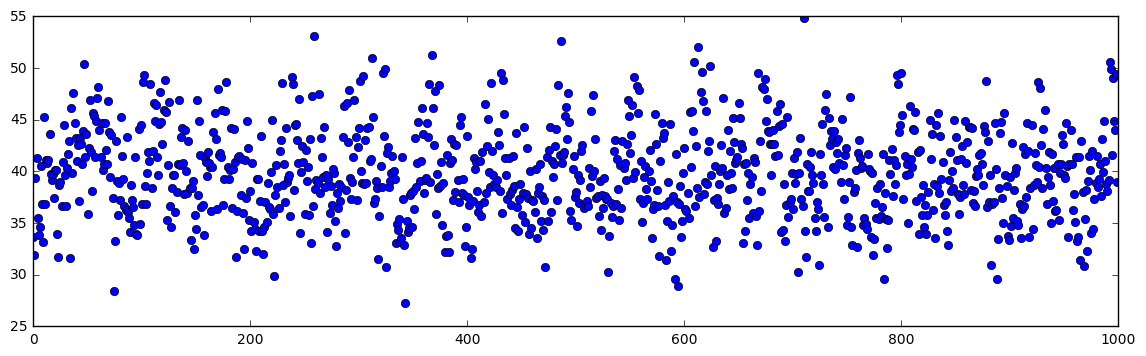

In [109]:
plt.figure(figsize=[14, 4])
plt.plot(np.arange(1000), lnlike, 'o')

In [110]:
gds = gradient_descent_ds(gds, detector, (results[:, 0], results[:, 1], results[:, 2]))
gds = gds/np.sum(gds)

39845.8571017
39835.0809415
39835.0809415
39823.3579483
39823.3579483
39810.6199015
39810.6199015
39796.7969921
39796.7969921
39781.8186602
39781.8186602
39765.6146914
39765.6146914
39748.1166285
39748.1166285
39729.2595561
39729.2595561
39708.9843308
39708.9843308
39687.2403335
39687.2403335
39663.988833
39663.988833
39639.2070552
39639.2070552
39612.8930627
39612.8930627
39585.071552
39585.071552
39555.8006782
39555.8006782
39525.1800146
39525.1800146
39493.3597435
39493.3597435
39460.5511553
39460.5511553
39427.0385024
39427.0385024
39393.1922079
39393.1922079
39359.4833648
39359.4833648
39326.4993786
39326.4993786
39294.960501
39294.960501
39265.7368733
39265.7368733
39239.8655606
39239.8655606
39218.5669028
39218.5669028
39203.2593757
39203.2593757
39195.5720527
39195.5720527
39197.3537486


In [111]:
#gdd = gradient_descent_dd(gds, gdd, (results[:, 0], results[:, 1], results[:, 2]))

In [112]:
results = np.array(results)
f_n, yc_n, xc_n = results[:, 0], results[:, 1], results[:, 2]

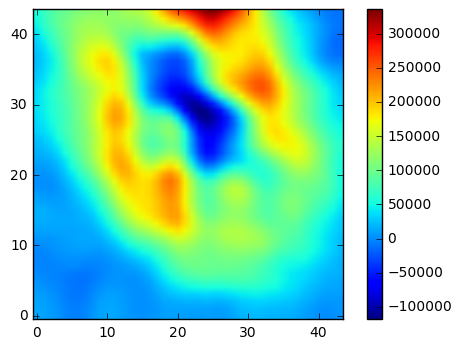

In [113]:
plt.imshow(dlnlike_ds, origin='lower')
plt.colorbar()

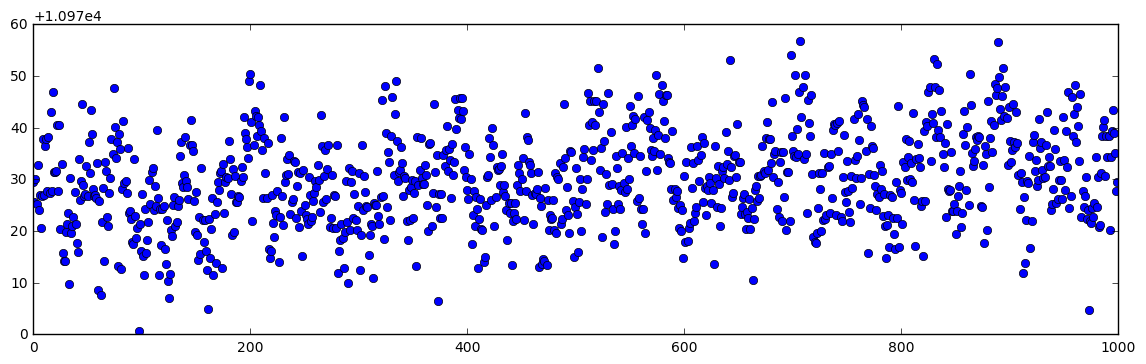

In [114]:
plt.figure(figsize=[14, 4])
plt.plot(np.arange(1000), np.log(f_n) * np.sum(np.exp(gds)), 'o')

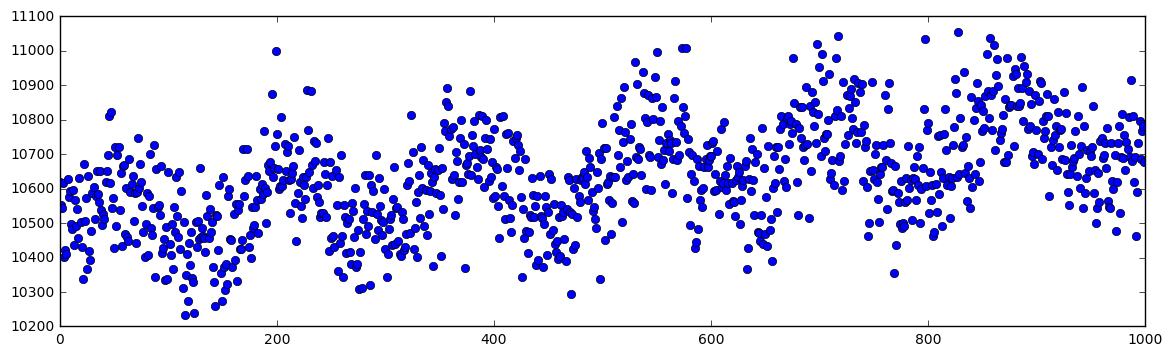

In [115]:
plt.figure(figsize=[14, 4])
plt.plot(np.arange(1000), np.sum(tpf_save, axis=(1, 2)), 'o')

In [123]:
pred_flux = [np.sum(np.exp(model(*results[i], gds) + model(1, 0, 0, detector))) for i in range(1000)] 

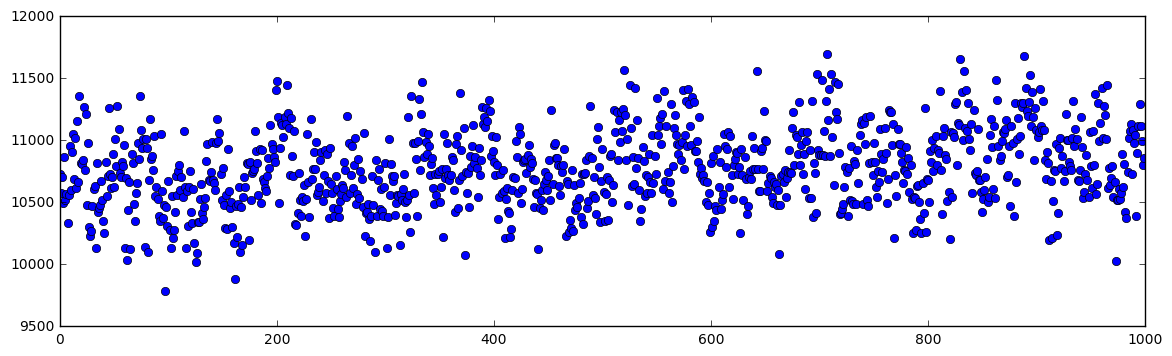

In [129]:
plt.figure(figsize=[14, 4])
plt.plot(np.arange(1000), pred_flux, 'o') # the model is larger than the data region

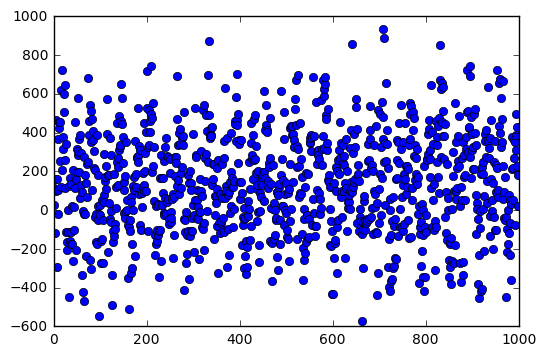

In [130]:
plt.plot(np.arange(1000), pred_flux-np.sum(tpf_save, axis=(1,2)), 'o') # the model is larger than the data region